# Concatenação

## Bibliotecas 

In [1]:
import pandas as pd
from datetime import datetime

## Bases

In [2]:
%%time
urls, htmls = pd.read_parquet('urls/bases/urls.parquet'), pd.read_parquet('2. htmls/bases/htmls.parquet')
dataframe = pd.merge(urls, htmls, on = 'url', how = 'right')

CPU times: total: 30.2 s
Wall time: 27.9 s


## Avaliação das fontes de data

In [3]:
# Ajuste dos formatos de data advindos de etapas adversas do processo de coleta...
dataframe.data_do_html = pd.to_datetime(dataframe.data_do_html.dt.date)
dataframe.data_da_busca = pd.to_datetime(dataframe.data_da_busca)

In [4]:
df_describe = pd.DataFrame({
    'data_da_url': (dataframe[['data_da_url', 'data_do_html']].dropna()
                    .assign(dif=lambda x: (x['data_da_url'] - x['data_do_html']).dt.days)
                    .dif.describe()),
    'data_da_busca': (dataframe[['data_da_busca', 'data_do_html']].dropna()
                      .assign(dif=lambda x: (x['data_da_busca'] - x['data_do_html']).dt.days)
                      .dif.describe()),
    'recorte': (dataframe[['recorte', 'data_do_html']].dropna()
                .assign(dif=lambda x: (x['recorte'] - x['data_do_html']).dt.days)
                .dif.describe())
}).T.round(0).astype(int)
display(df_describe)

,count,mean,std,min,25%,50%,75%,max
data_da_url,849594,0,1,-472,0,0,0,154
data_da_busca,1250336,46,339,-774,0,0,0,4801
recorte,1250336,1,27,-774,0,0,0,3780


As datas do HTML e da URL convergem, mas há mais das primeiras (1.250.336) do que das segundas (849.594).

<p style="text-align:justify"'>Todas as notícias possuem recorte, é a data do dia utilizado em sua busca ou indexador de seu sitemap. Ademais, converge com as anteriores, salvo pelo fato observado empiricamente de, por vezes, haver notícias do dia anterior ou seguinte na busca ou sitemap de determinado dia. Portanto, apesar de confiável, o recorte apresenta tal pequena divergência.</p>

Por outro lado, a data da busca é a que mais diverge, parecendo pouco confiável.

Sendo assim, adotará-se, na ordem, a data do HTML, da URL e do recorte. A data da busca será descartada, portanto, pois todas as notícias já possuem recorte.

## Ajustes complementares

In [5]:
df = dataframe.copy()
df = df[~df.url.str.contains('globorural.globo.com/vida-na-fazenda/')] # Removendo receitas do Globo Rural.
df['data'] = df.data_do_html.fillna(df.data_da_url.fillna(df.recorte)) # Data por ordem de confiabilidade.
df = df[(df.data >= datetime(2011,8,1)) & (df.data < datetime(2025,2,1))].copy() # Somentes meses inteiros.

In [6]:
%%time
df.to_parquet('urls e htmls.parquet', engine = 'pyarrow') # Finalmente, agora sem erros, armazenando...

CPU times: total: 32.5 s
Wall time: 34.3 s


# Filtro e refino

Recomenda-se reiniciar o kernel antes de proceder.

In [1]:
from redação import *
import gc
import multiprocessing as mp

In [2]:
referência = ['url', 'data']
variáveis = ['manchete', 'resumo', 'conteúdo']
df = pd.read_parquet('urls e htmls.parquet', columns = referência + variáveis)

In [3]:
%%time
for variável in variáveis:

    # Nova coluna
    filtro = 'filtro de ' + variável
    refino = 'refino de ' + variável

    # Tratamento
    with mp.Pool(mp.cpu_count()) as pool:
        
        # Filtro de tamanho
        df[filtro] = pool.map(filtrar, df[variável])

        # Limpando a memória
        del df[variável]
        gc.collect()

        # Refino do conteúdo
        df[refino] = pool.map(refinar, df[filtro])

CPU times: total: 29.8 s
Wall time: 23min 23s


In [5]:
%%time
df[[column for column in df.columns if 'refino' not in column]].to_parquet('base filtrada.parquet', engine = 'pyarrow')
df[[column for column in df.columns if 'filtro' not in column]].to_parquet('base refinada.parquet', engine = 'pyarrow')

CPU times: total: 8.64 s
Wall time: 8.67 s


# Malha fina

Recomenda-se reiniciar o kernel antes de proceder.

## Bibliotecas e bases

In [1]:
import pandas as pd
from redação import reduzir_espaços

base = pd.read_parquet('base refinada.parquet')
base.columns = ['url', 'data', 'manchete', 'resumo', 'conteúdo']

In [2]:
manchetes_inócuas = [ 
    
    'destaques', 'curtas', 'frase dia', 'movimento falimentar', 
    'curta', 'leia manchetes principais jornais brasileiros',
    'commodities agrícolas', 'agenda', 'cartas leitores', 'destaque',
    'correção', 'destaques dia notícia', 'valor.com.br', 'indicadores',
    'avant-première', 'valor pauta ouça análises temas movimentar mercado',
    'blue chip', 'precisa saber acompanhar',
    'leia manchetes principais jornais país',
    'acerta mega-sena prêmio números sorteados',
    'mega-sena sorteia prêmio estimado apostar bolão', 
    'vaivém', 'correções', 'contexto'
    
] # Repetem-se mais que 0.01% das vezes, exceto por 'dólar ptax fecha alta'.

In [4]:
%%time
df = base.copy()
df.manchete = df.manchete.apply(lambda manchete: '' if manchete in manchetes_inócuas else manchete)
df = df[df.manchete != ''].copy()

base_parcial = df.copy() # Somente manchetes.
base_parcial['corpus'] = base_parcial.manchete.apply(reduzir_espaços) 
base_parcial['numpal'] = base_parcial.corpus.str.count(' ') + 1 # Número de palavras por corpus.
base_parcial = base_parcial[base_parcial.numpal > 1].copy()

base_total = df.copy() # Manchete, resumo e '1º parágrafo'.
base_total['corpus'] = (base_total.manchete + ' ' + base_total.resumo + ' ' + base_total.conteúdo).apply(reduzir_espaços)
base_total['numpal'] = base_total.corpus.str.count(' ') + 1 # Número de palavras por corpus.
base_total = base_total[base_total.numpal > 3].copy()

CPU times: total: 9.55 s
Wall time: 9.54 s


In [5]:
%%time
base_parcial[['url', 'data', 'numpal', 'corpus']].to_parquet('base parcial após malha fina.parquet', engine = 'pyarrow')
base_total[['url', 'data', 'numpal', 'corpus']].to_parquet('base total após malha fina.parquet', engine = 'pyarrow')

CPU times: total: 5.11 s
Wall time: 5.08 s


# Estatísticas preliminares

Recomenda-se reiniciar o kernel antes de proceder.

## Bibliotecas e funções

In [5]:
import pandas as pd # Tabelas
import numpy as np # Matrizes
import matplotlib.pyplot as plt # Gráficos
from matplotlib.ticker import FuncFormatter # Formatação de gráficos
import seaborn as sns # Gráficos mais avançados
from IPython.display import HTML # Visualização de HTML no Jupyter

base = pd.read_parquet('base refinada.parquet')
base_parcial = pd.read_parquet('base parcial após malha fina.parquet')
base_total = pd.read_parquet('base total após malha fina.parquet')

cores = {
    
    'valor': (0/255, 98/255, 105/255),
    'valorinveste': (71/255, 47/255, 146/255),
    'pipelinevalor': (158/255, 0/255, 93/255),
    'globorural': (52/255, 131/255, 68/255),
    'epocanegocios': (0/255, 0/255, 0/255),
    'revistapegn': (246/255, 84/255, 17/255),
    'umsoplaneta': (97/255, 155/255, 19/255),
    
}

formatter = FuncFormatter(lambda x, _: f'{int(x/1000):,}k')

def avaliar_base_parcial(portal, base, base_parcial):
    display(HTML(f'Após o tratamento, a base possui <b>{100*len(base_parcial)/len(base):.2f}%</b> de seu tamanho original.\n'))
    display(HTML(f'Nº médio de palavras por documento após tratamento: <b>{int(base_parcial.numpal.mean())}</b>.'))

    cor = (200/255, 200/255, 200/255) if portal not in cores else cores[portal]
    plt.figure(figsize=(15, 3), dpi=150)
    plt.title('Histograma de notícias por nº de palavra na base parcial após malha fina')
    bins = np.arange(base_parcial.numpal.min() - 0.5, base_parcial.numpal.max() + 1.5, 1)
    plt.hist(base_parcial.numpal, bins = bins, color = cores[portal], edgecolor = 'white')
    plt.xticks(range(base_parcial.numpal.min(), base_parcial.numpal.max() + 1))
    plt.xlim(1,15)
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.show()

def avaliar_base_total(portal, base, base_total):
    display(HTML(f'Após o tratamento, a base possui <b>{100*len(base_total)/len(base):.2f}%</b> de seu tamanho original.\n'))
    display(HTML(f'Nº médio de palavras por documento após tratamento: <b>{int(base_total.numpal.mean())}</b>.'))

    cor = (200/255, 200/255, 200/255) if portal not in cores else cores[portal]
    plt.figure(figsize = (15, 3), dpi = 300)
    plt.title('Distribuição de notícias por nº de palavra na base total após malha fina')
    sns.kdeplot(base_total['numpal'], fill = True, color = cores[portal])
    plt.xlim(0,150)
    plt.ylabel(None)
    plt.show()

### Avaliação: base parcial

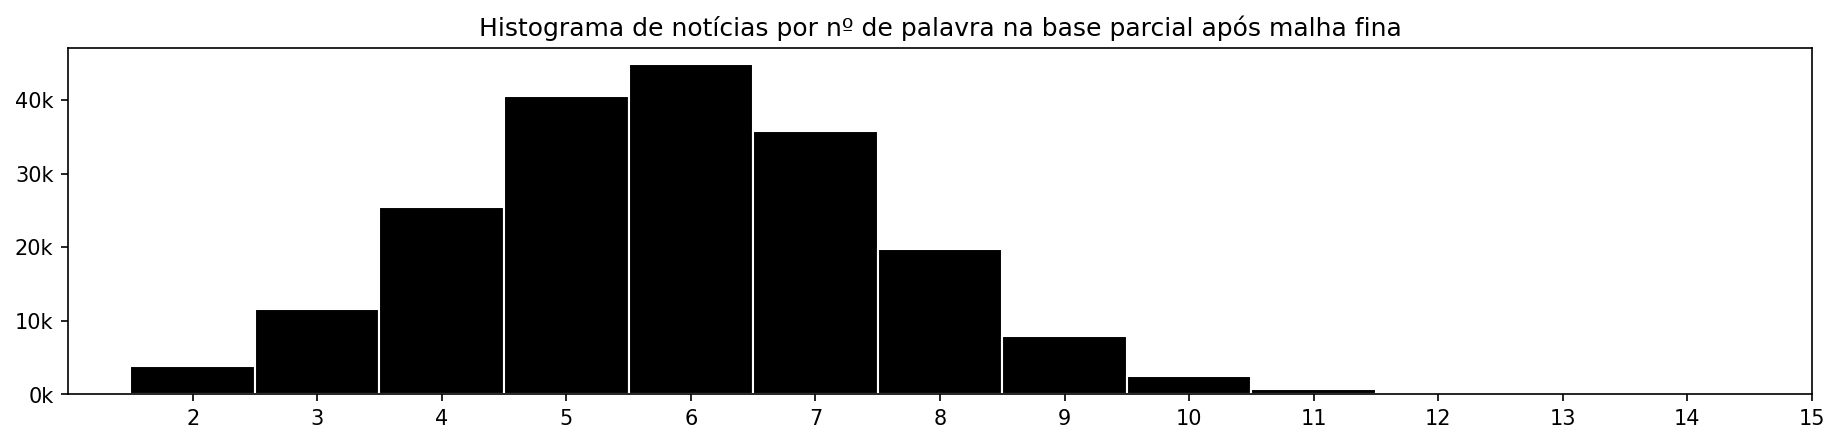

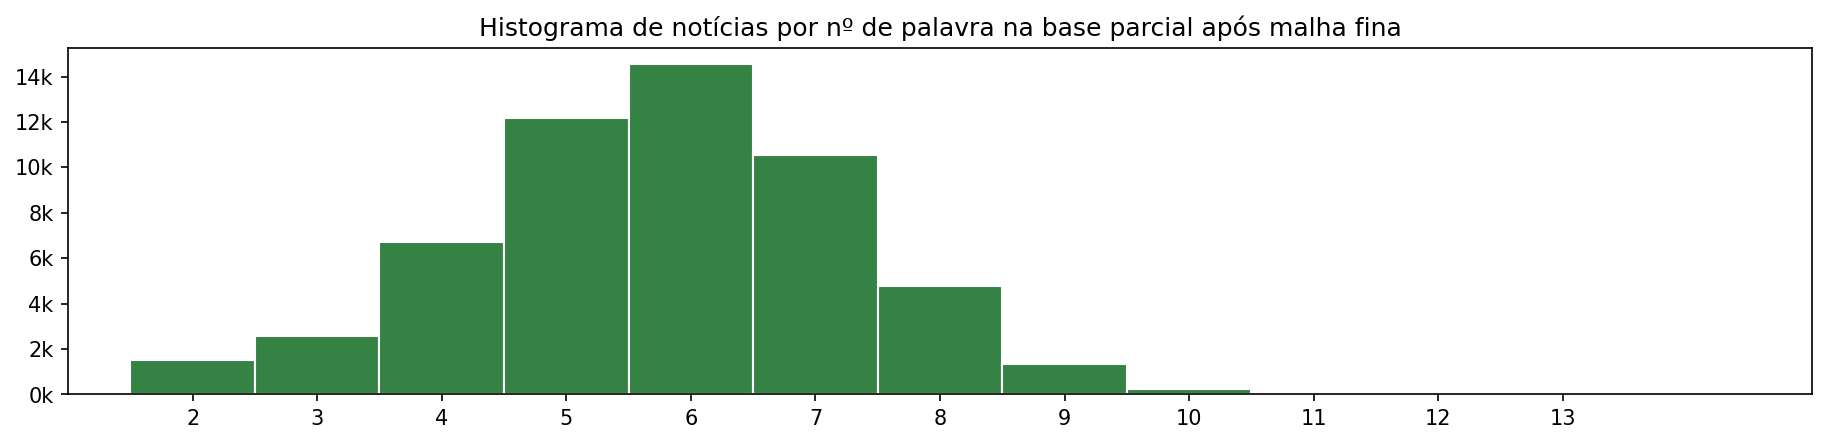

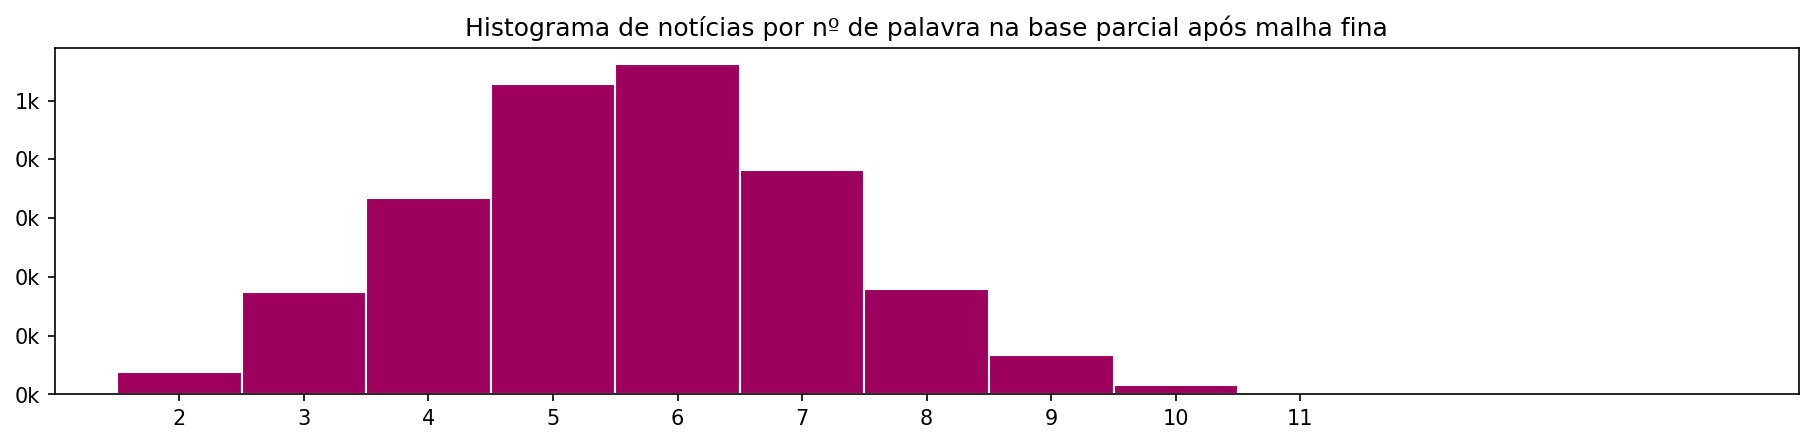

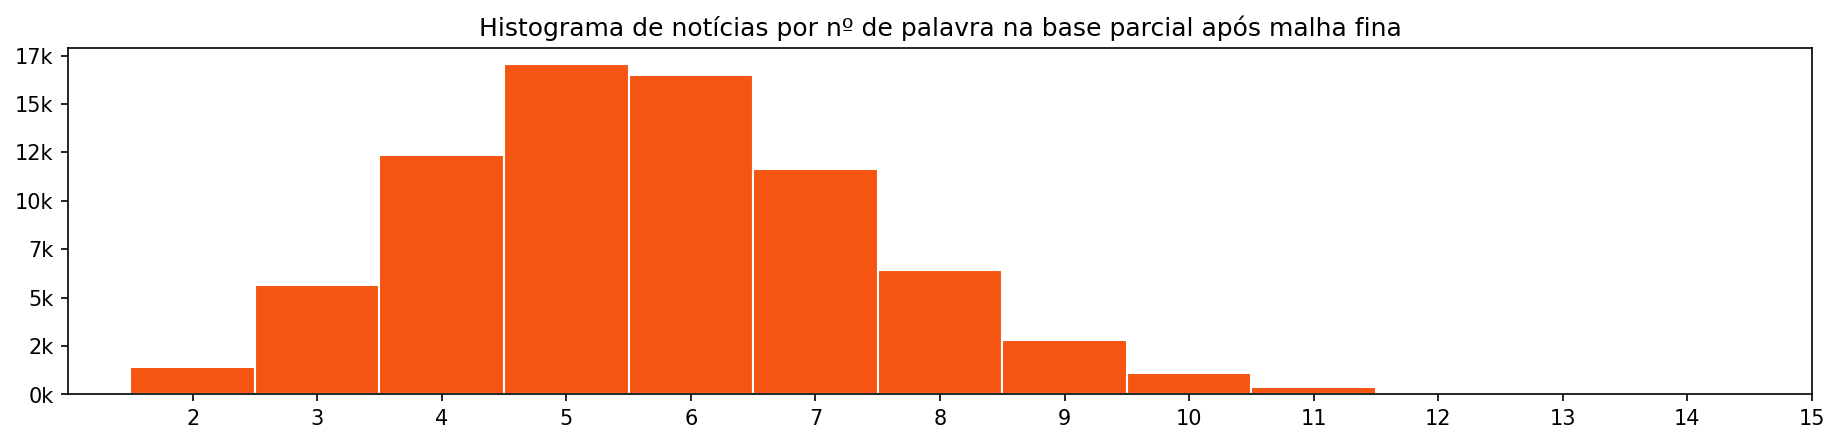

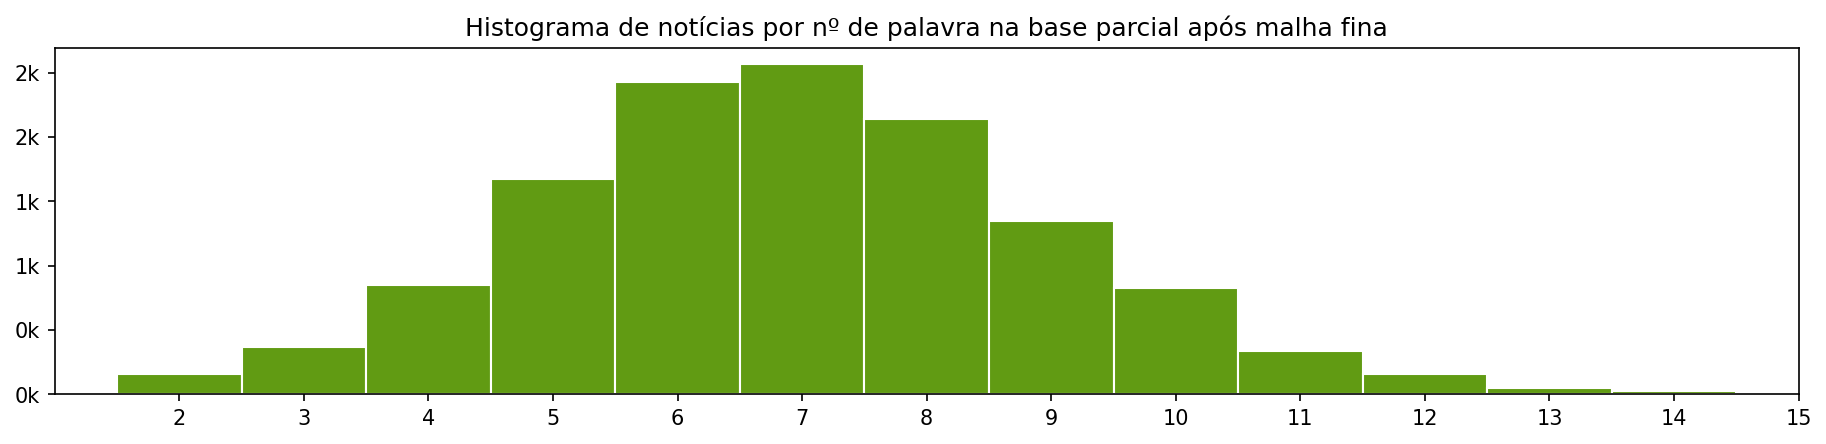

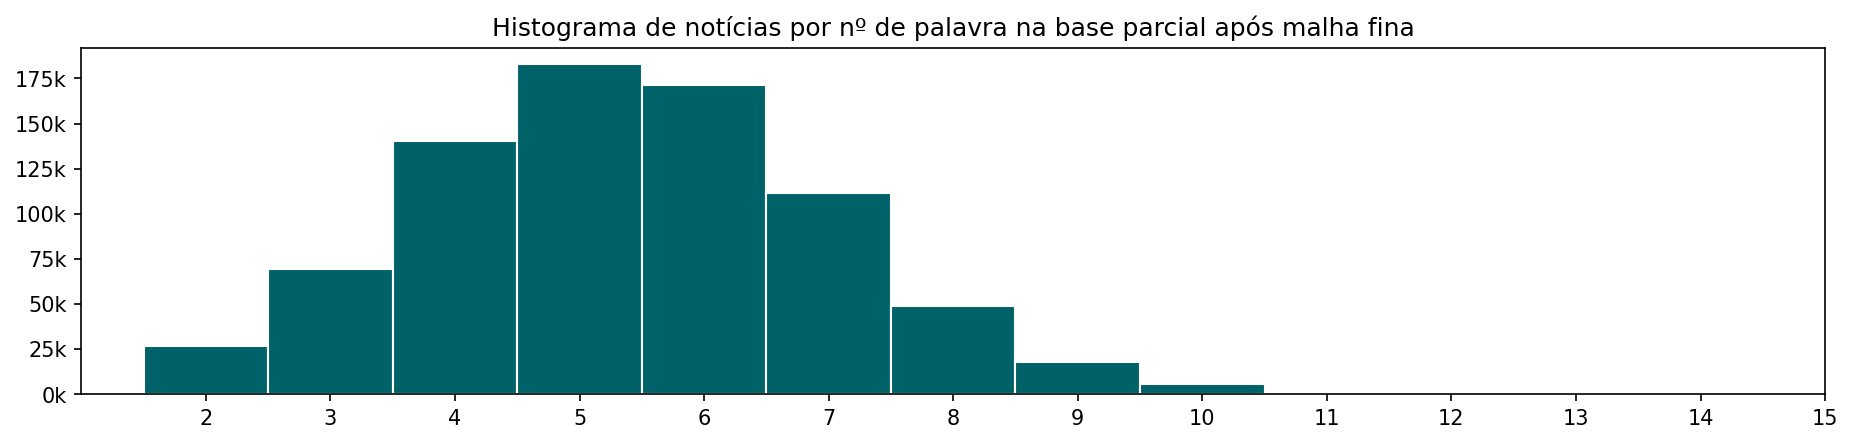

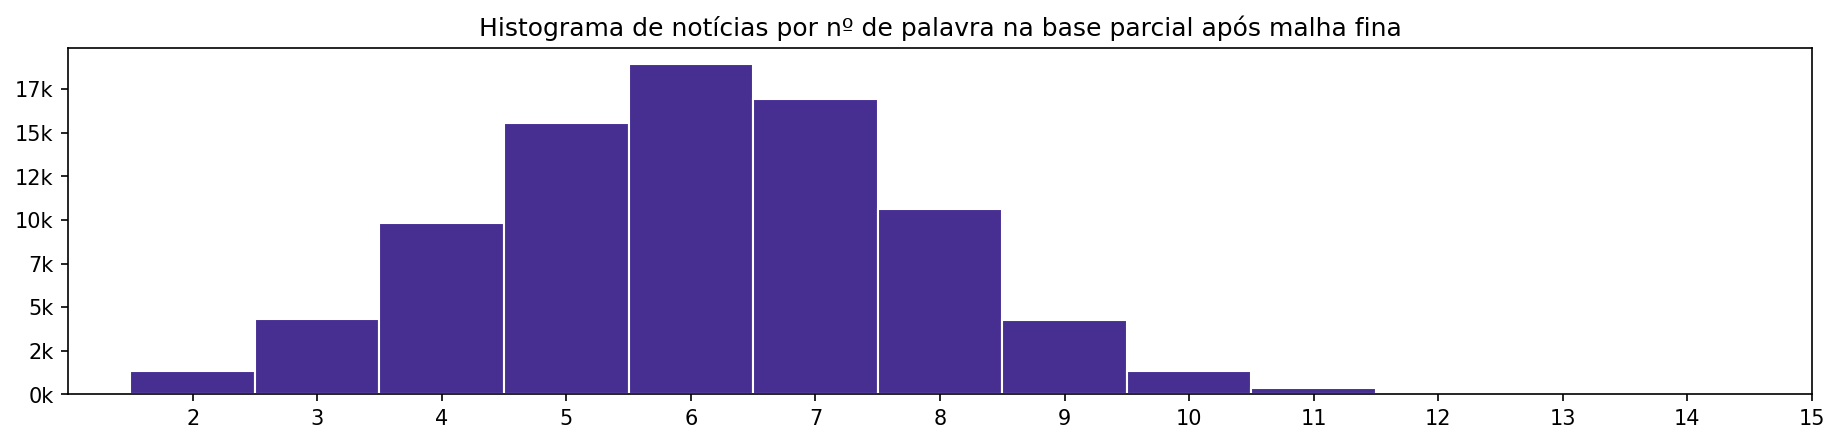

In [6]:
for portal in sorted(cores.keys()):
    display(HTML(f'<h4>{portal}</h4><hr>'))
    referência = portal + '.globo.com/'
    avaliar_base_parcial(portal,
                         base[base.url.str.contains(referência)],
                         base_parcial[base_parcial.url.str.contains(referência)])

### Avaliação: base total

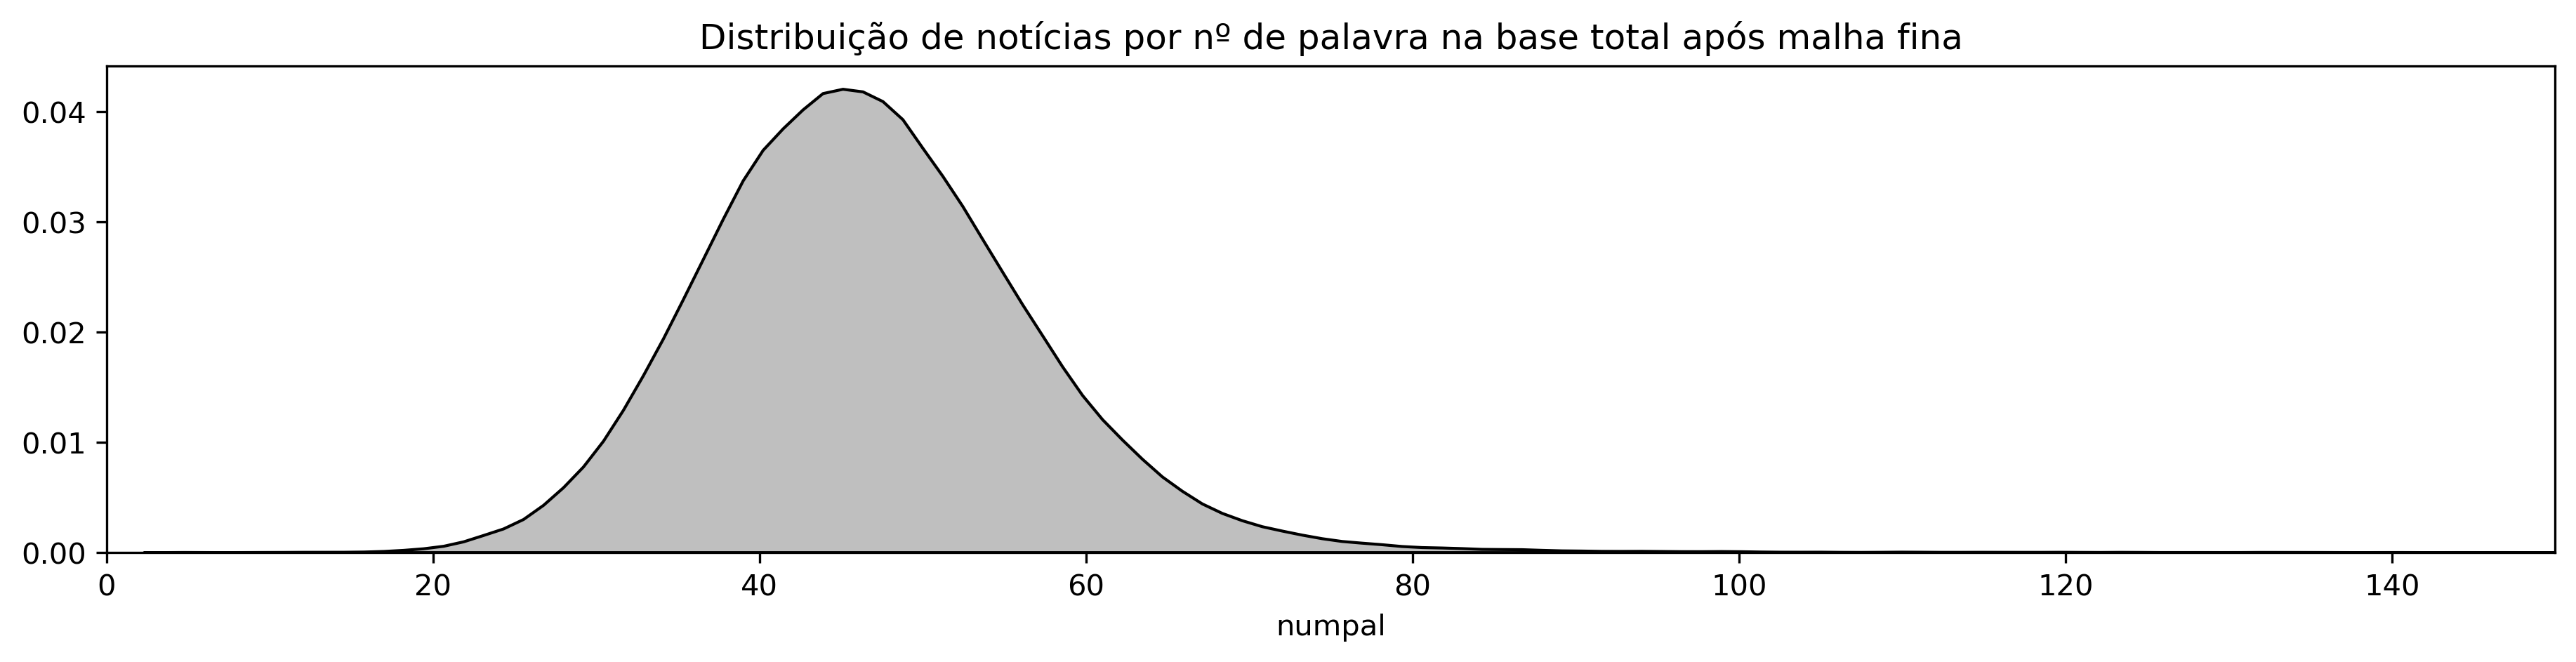

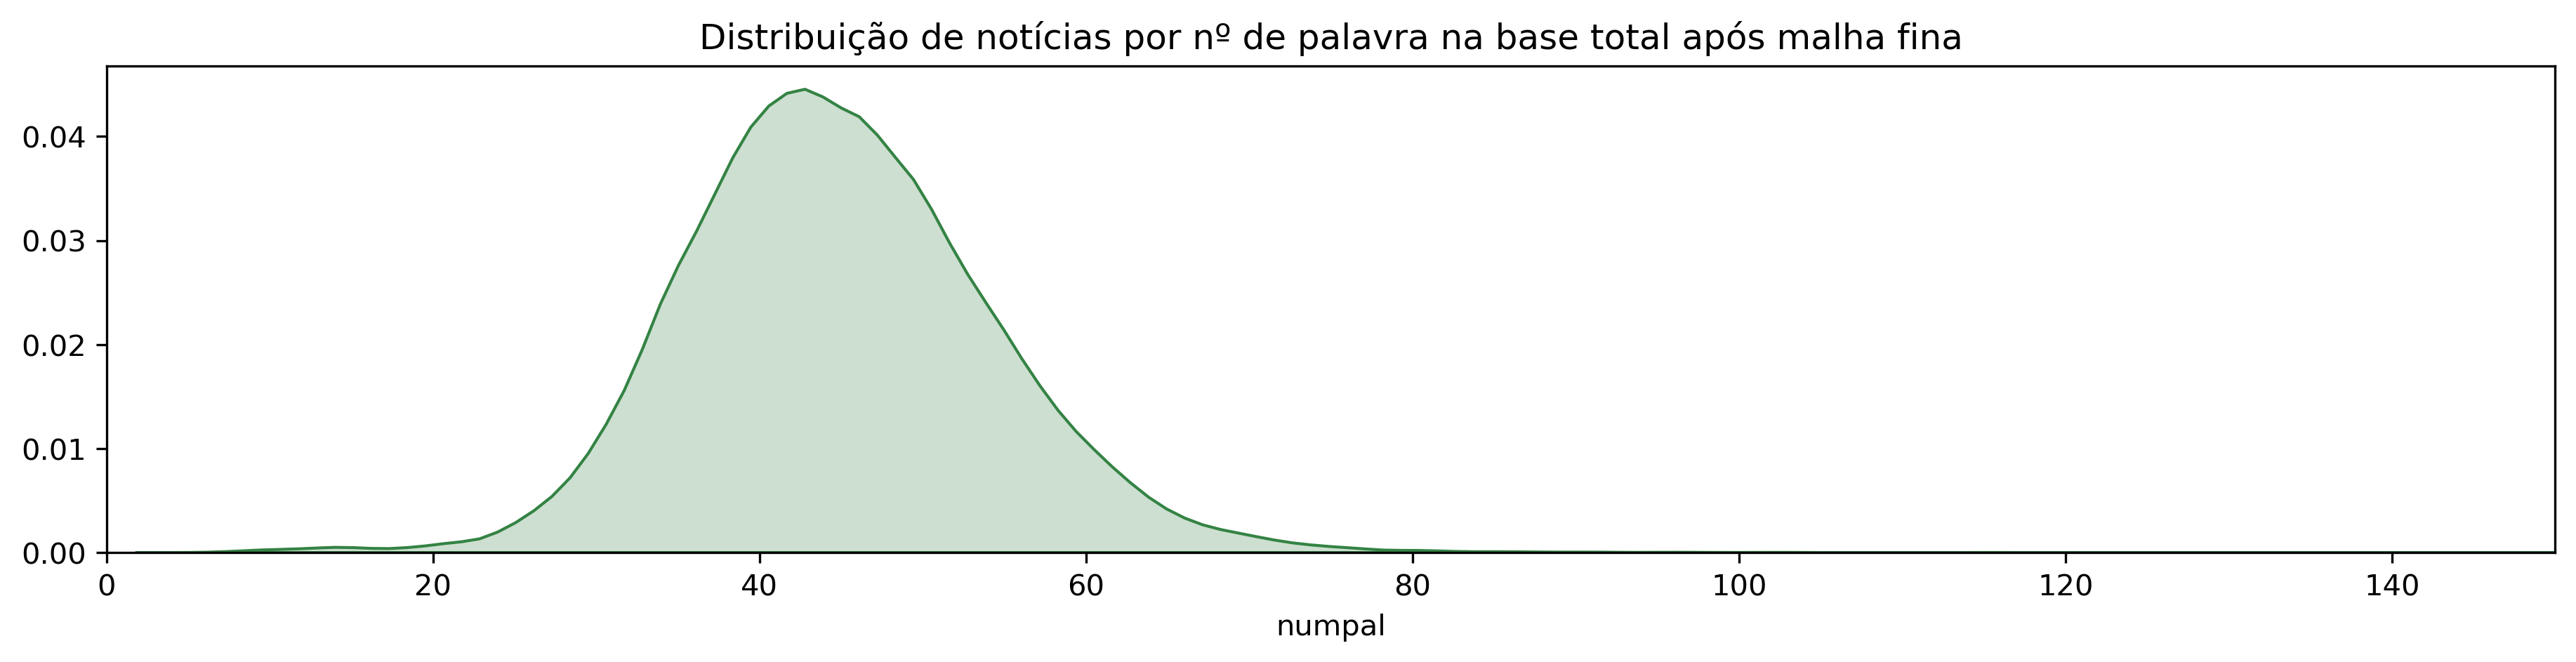

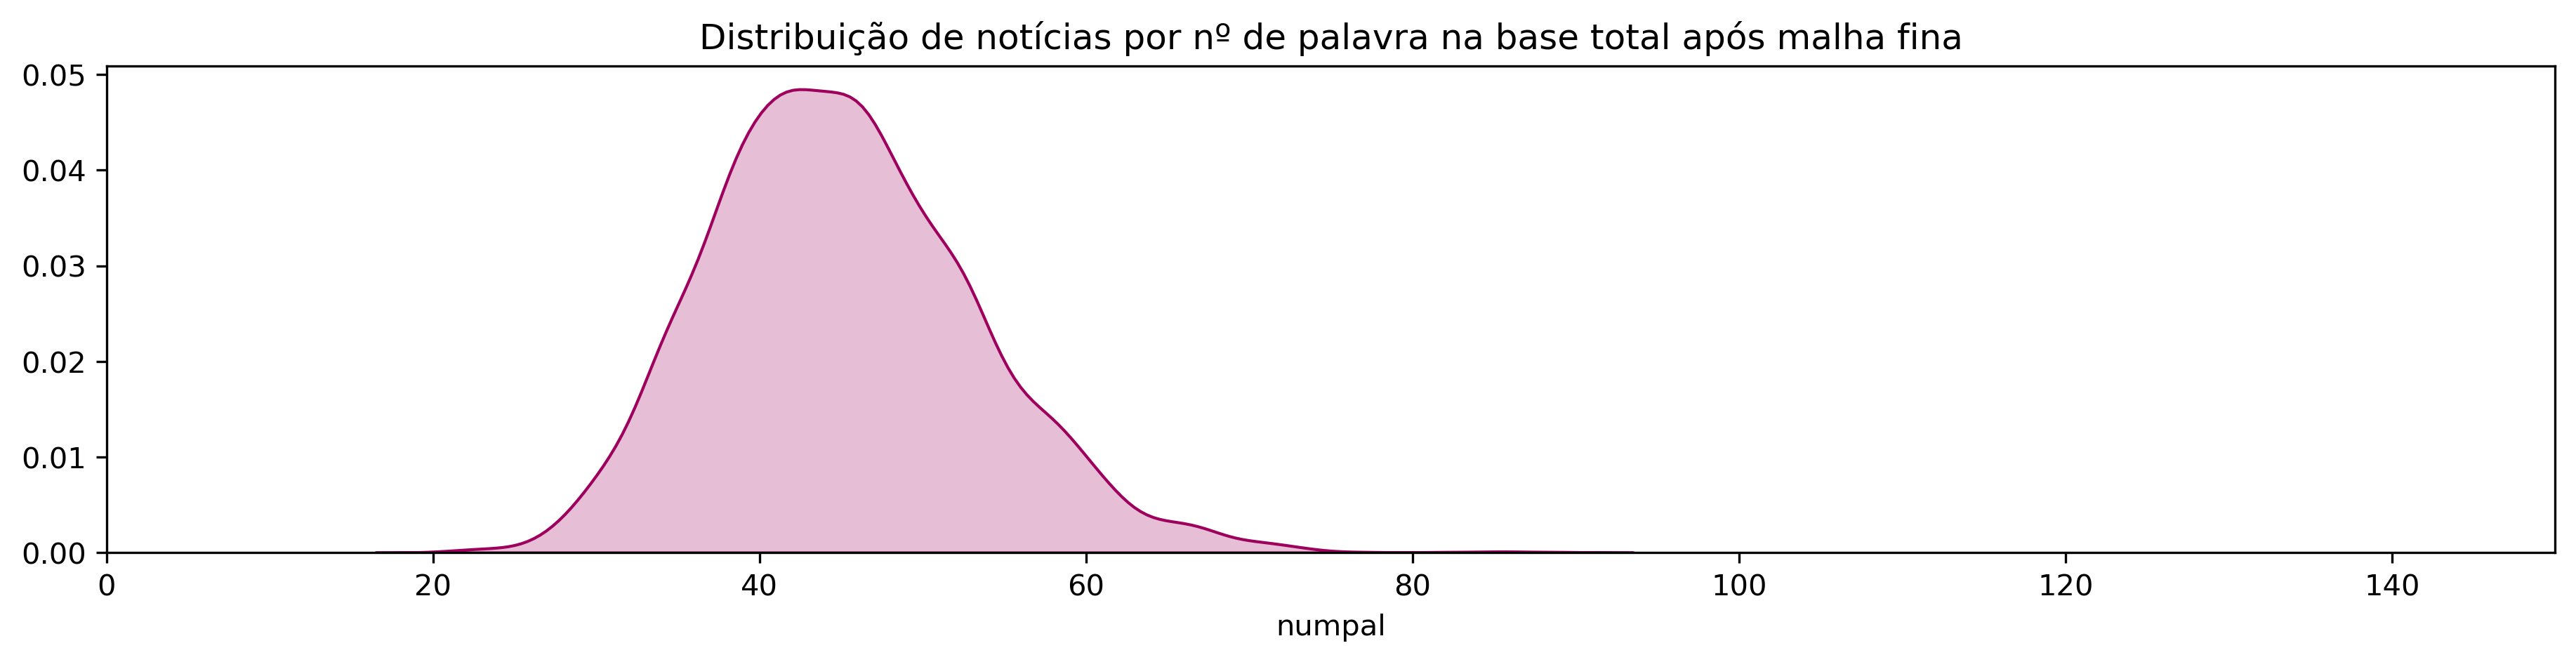

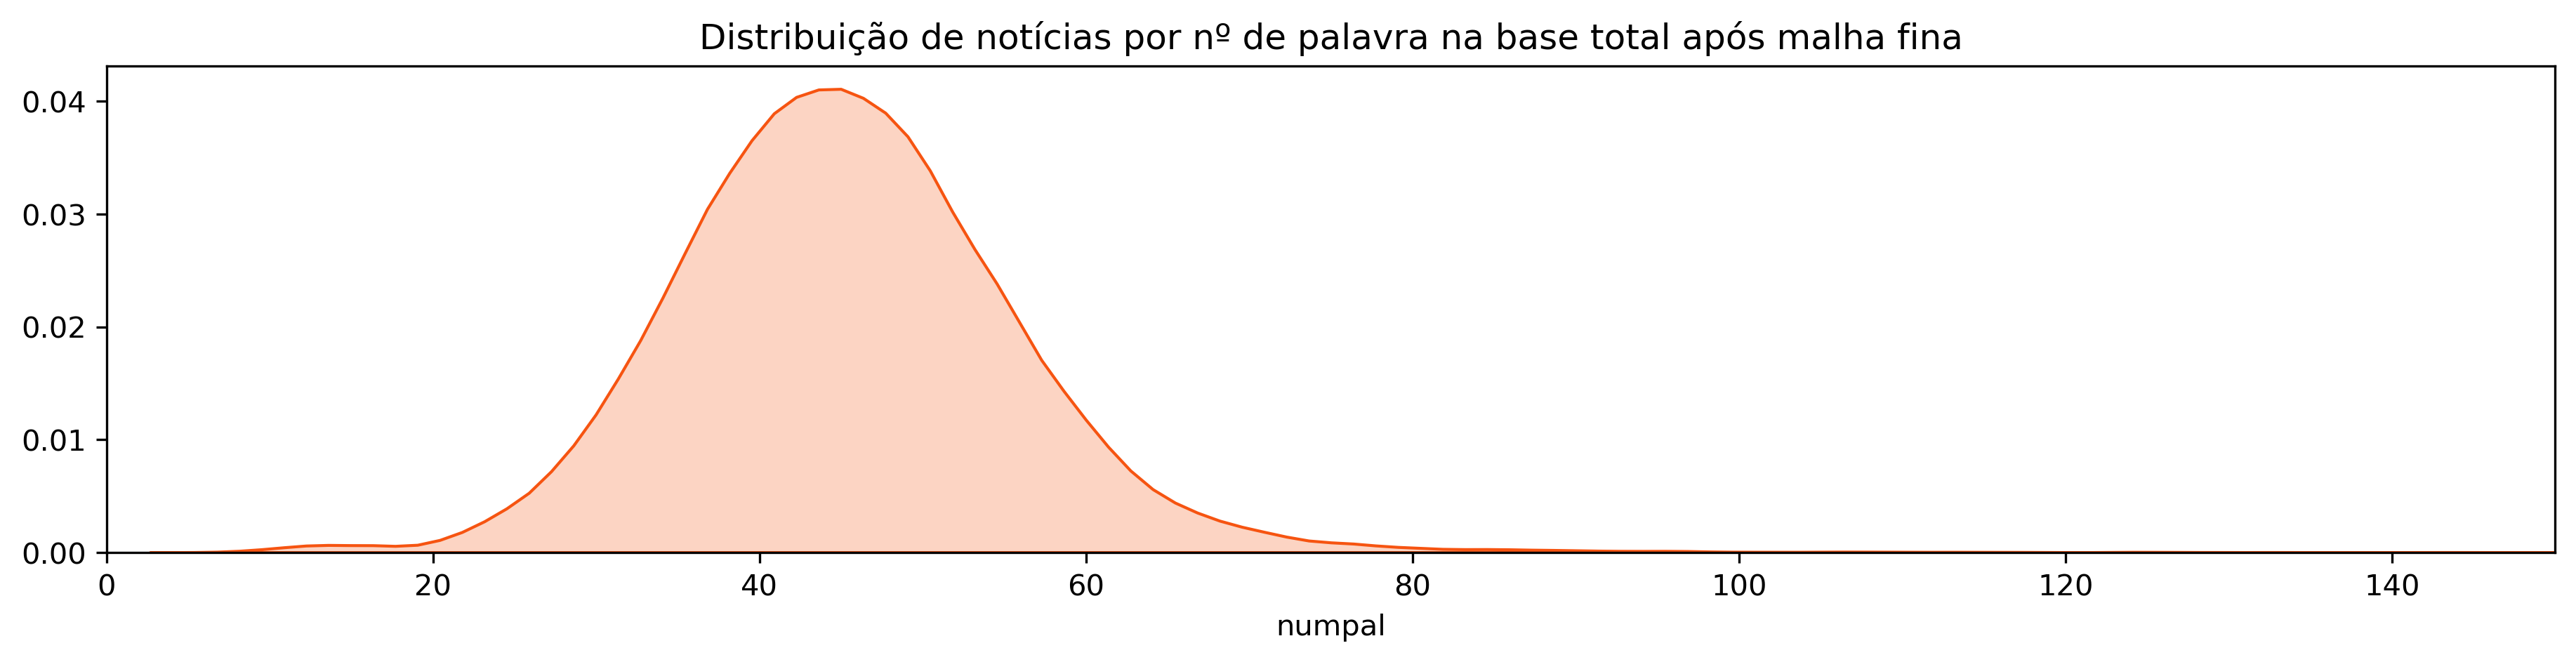

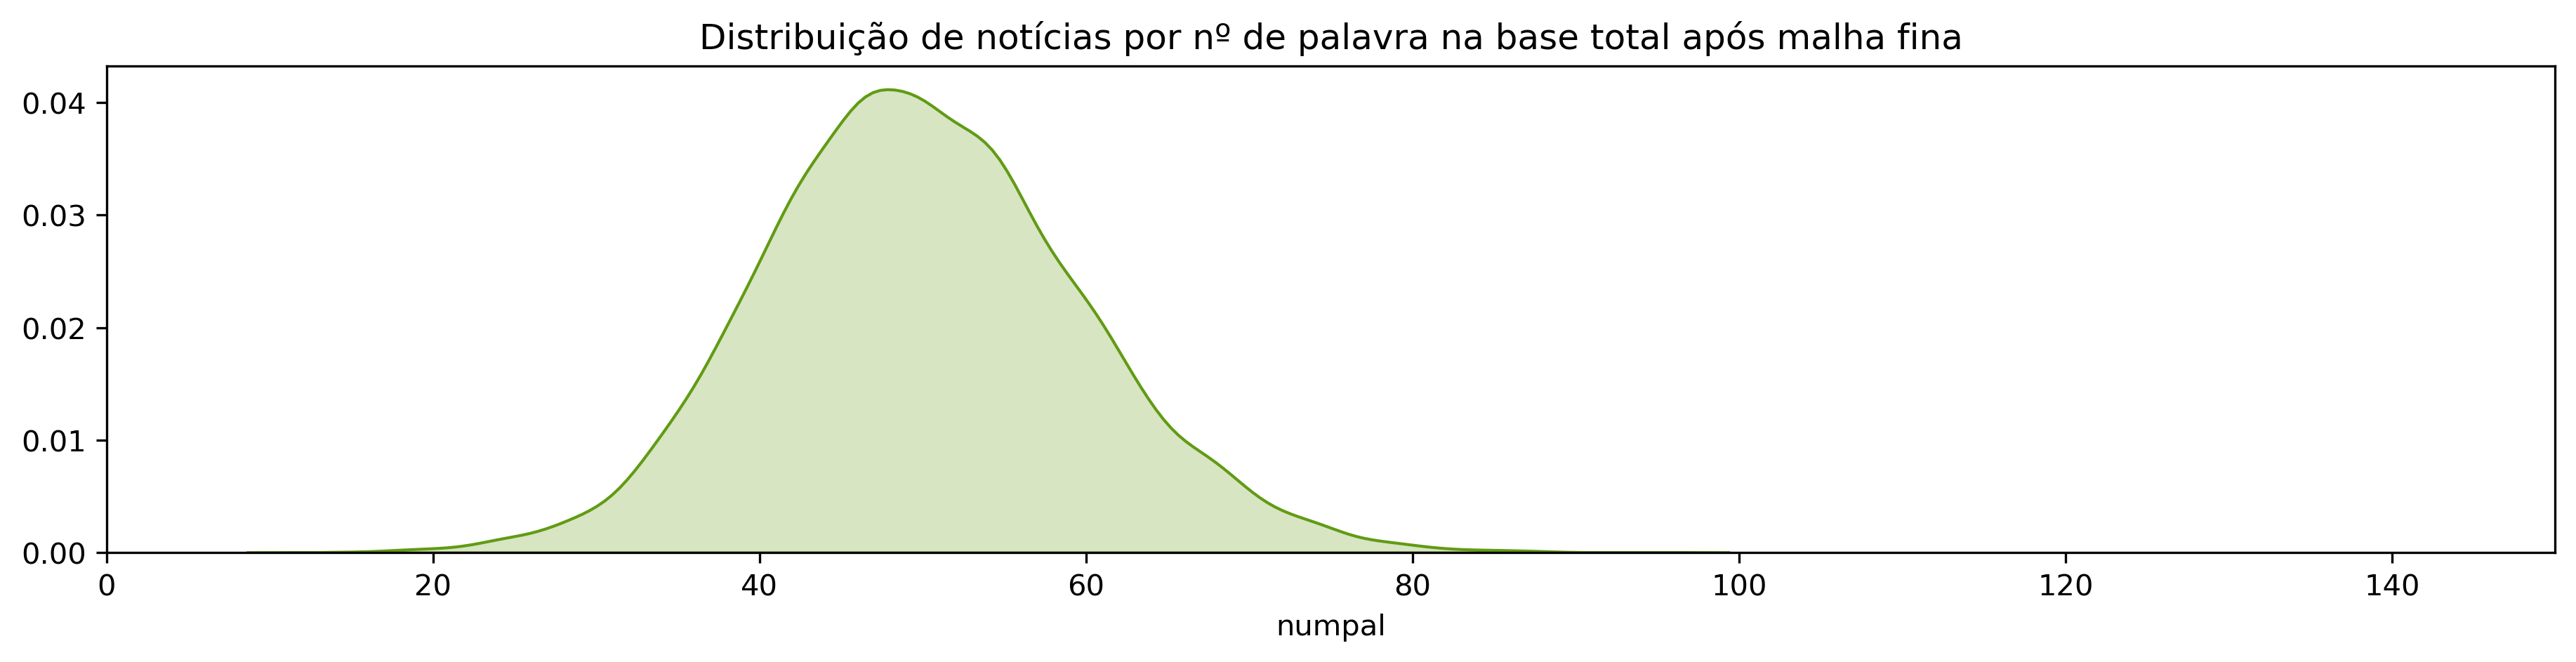

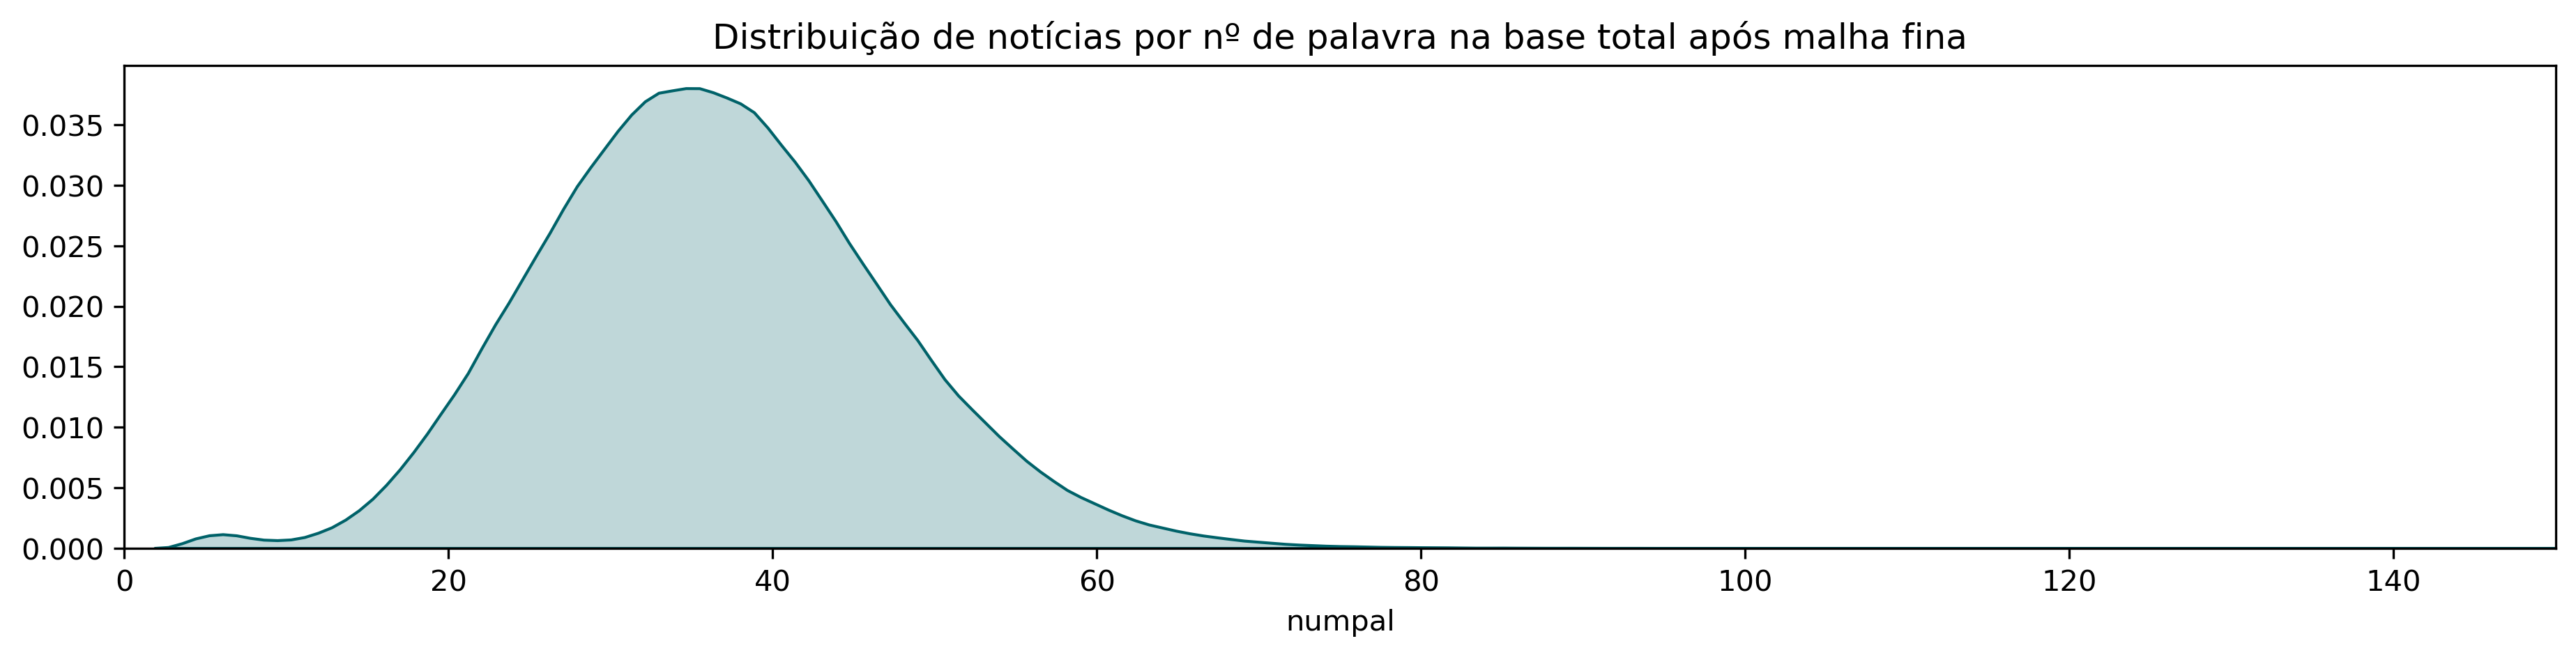

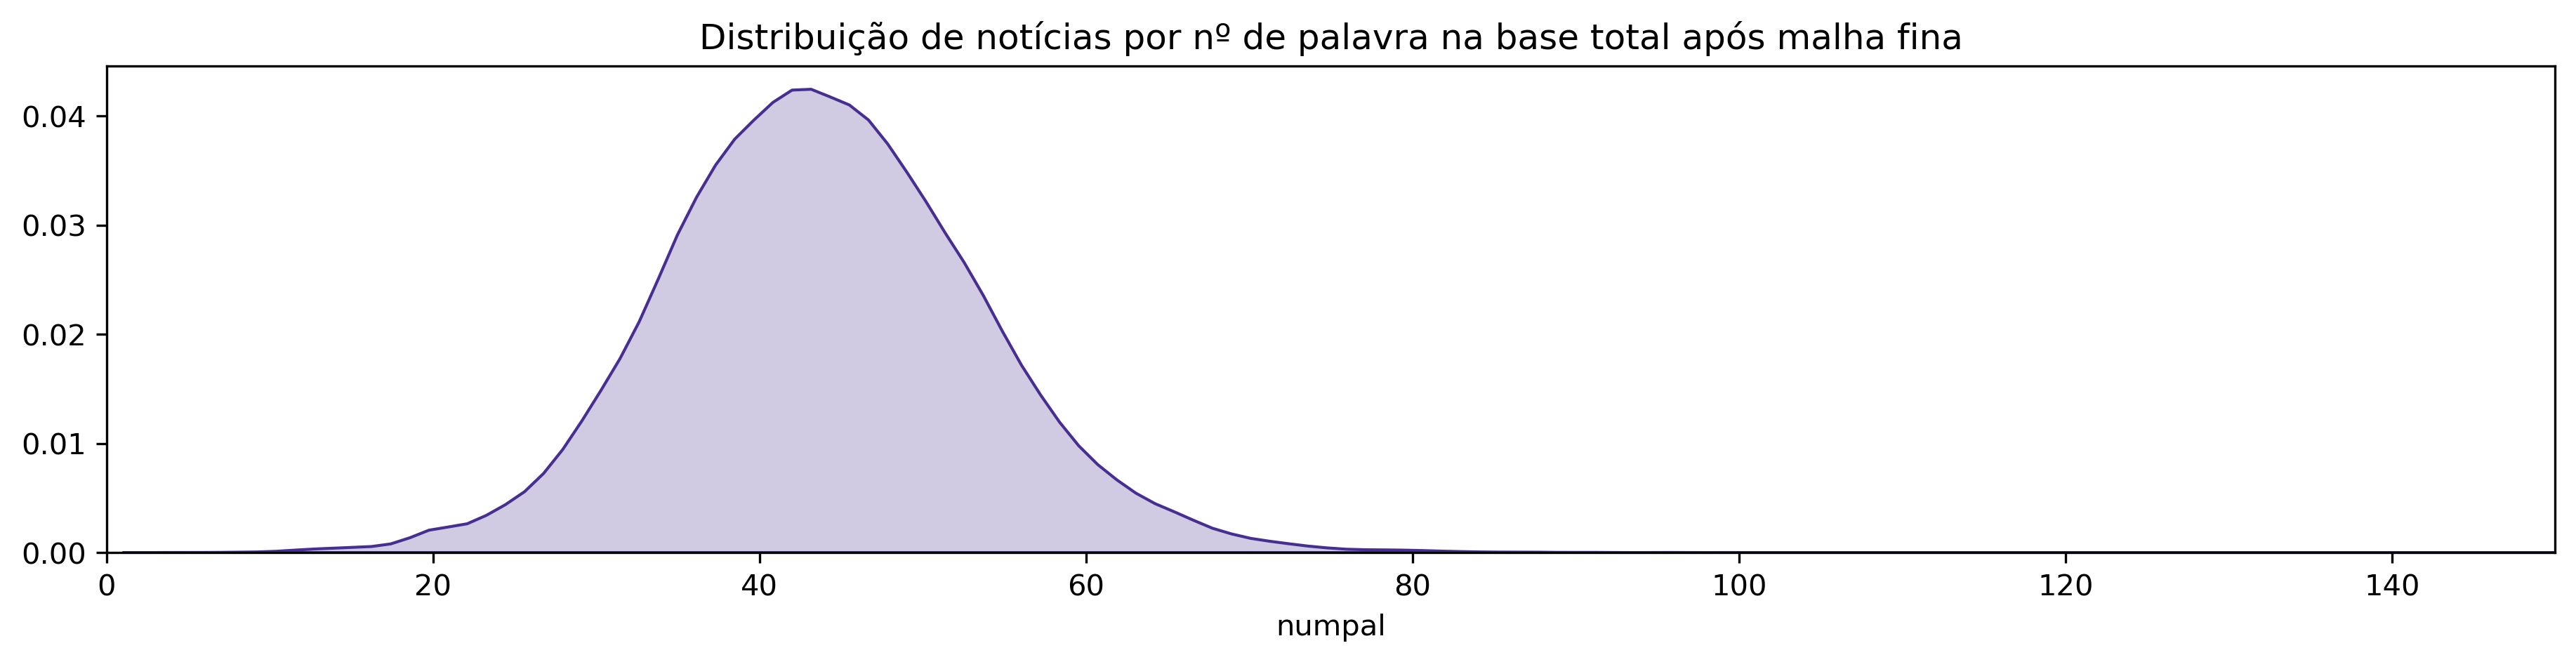

In [7]:
for portal in sorted(cores.keys()):
    display(HTML(f'<h4>{portal}</h4><hr>'))
    referência = portal + '.globo.com/'
    avaliar_base_total(portal,
                       base[base.url.str.contains(referência)],
                       base_total[base_total.url.str.contains(referência)])

# Palavreado

Recomenda-se reiniciar o kernel antes de proceder.

## Bibliotecas e bases

In [2]:
from revisor import *

import pandas as pd # Tabelas
from collections import Counter # Contador de palavras únicas
import multiprocessing as mp # Paralelização de processos
from functools import partial # Pré-preencher funções para paralelização
from time import perf_counter # Cronômetro

from pathlib import Path # Organização de pastas no computador
(Path('palavreados')).mkdir(parents = True, exist_ok = True)
(Path('palavras frequentes')).mkdir(parents = True, exist_ok = True)
(Path('bases para o LDA')).mkdir(parents = True, exist_ok = True)

bases = [pd.read_parquet('base parcial após malha fina.parquet')[['url', 'data', 'corpus']], 
         pd.read_parquet('base total após malha fina.parquet')[['url', 'data', 'corpus']]]

for base in bases: # Categorizando dados por portal.
    base['portal'] = base.url.str.replace('revistagloborural', # Revista Globo Rural e Globo Rural são o mesmo portal!
                                          'globorural').apply(lambda url: url.split('/')[2].split('.')[0])

<p style="text-align:justify">Ao remover duplicatas dentro de cada notícia, o somatório de suas ocorrências será o nº de vezes que as palavras aparecem nos artigos, e não o nº total. Assim, palavras que aparecem muito, mas em poucos artigos, são penalizadas. Por outro lado, a diversificação favorece a seleção posterior..! Nela, somente palavras que aparecem em x% dos artigos serão toleradas, enquanto as demais serão descartadas.</p>

In [3]:
seleções = {

    # Portais individuais
    'pipelinevalor': ['pipelinevalor'],
    'umsoplaneta': ['umsoplaneta'],
    'globorural': ['globorural'],
    'revistapegn': ['revistapegn'],
    'valorinveste': ['valorinveste'],
    'epocanegocios': ['epocanegocios'],
    'valor': ['valor'],

    # Portais agregados
    # 'agregação 1': ['valor', 'globorural'],
    # 'agregação 2': ['valor', 'globorural', 'epocanegocios'],
    # 'agregação 3': ['valor', 'globorural', 'epocanegocios', 'revistapegn'],
    # 'agregação 4': ['valorinveste', 'valor', 'globorural', 'epocanegocios', 'revistapegn'],
    # 'agregação 5': ['pipelinevalor', 'valorinveste', 'valor', 'globorural', 'epocanegocios', 'umsoplaneta', 'revistapegn']
    
}

In [4]:
for seleção in seleções:
    for recorte, base in zip(['parcial', 'total'], bases):

        # Mínimo de ocorrências em documentos diferentes em % do total de documentos.
        porcentagem = 0.1 if recorte == 'total' else 0.01
    
        # Segmentando a base por seleção, além da base inteira.
        filtro = base.portal.isin(seleções[seleção])
        df = base[filtro].copy() 

            # Ajustando o recorte para quando todos os portais possuem dados
        data_mínima_comum = df[['portal', 'data']].groupby('portal').min().data.max()
        df = df[df.data > data_mínima_comum].copy()

        
        # Removendo duplicatas dentro de cada artigo.
        base_sem_palavras_duplicadas = base[filtro].copy()
        with mp.Pool(mp.cpu_count()) as pool:
            base_sem_palavras_duplicadas.corpus = pool.map(remover_palavras_duplicadas, 
                                                           base_sem_palavras_duplicadas.corpus)
    
        
        # Contando o nº de ocorrência das palavras..!
        
        corpus = ' '.join(base_sem_palavras_duplicadas.corpus.tolist())
        palavreado = Counter(corpus.split(' '))
        
        palavreado = pd.DataFrame([list(palavreado.keys()), 
                                   list(palavreado.values())],
                                  index = ['palavra', 'ocorrência']).T.sort_values('ocorrência', ascending = False)
        
        palavreado['frequência'] = 100 * palavreado.ocorrência / len(base_sem_palavras_duplicadas)
    
        
        # Seleção das mais frequentes.
        palavras_frequentes = palavreado[palavreado.frequência > porcentagem][['palavra']].copy()
        palavras_frequentes.to_parquet(f'palavras frequentes/{seleção} - {recorte}.parquet', engine = 'pyarrow')
    
    
        # Exclusão de palavras raras.
    
        print(f'Lendo: {seleção} - {recorte}.')
        início = perf_counter()
        with mp.Pool(mp.cpu_count()) as pool:  
            filtrar_palavreado_parcial = partial(filtrar_palavreado, palavras_frequentes = palavras_frequentes.palavra.tolist())  
            df.corpus = pool.map(filtrar_palavreado_parcial, df.corpus)
    
        df = df[df.corpus != ''].copy() # Para notícias obliteradas.
        
    
        # Finalmente, arquivando!
        df.to_parquet(f'bases para o LDA/{seleção} - {recorte}.parquet', engine = 'pyarrow')
        fim = perf_counter()
        
        intervalo = fim - início
        minutos = int(intervalo/60)
        segundos = int(intervalo - minutos*60)
        print(f'Tempo decorrido: {minutos}m{segundos}s.\n')
        
        # Para revisão...
        palavreado.to_excel(f'palavreados/palavreado por artigo em {seleção} - {recorte}.xlsx', index = False)

Lendo: pipelinevalor - parcial.
Tempo decorrido: 0m0s.

Lendo: pipelinevalor - total.
Tempo decorrido: 0m2s.

Lendo: umsoplaneta - parcial.
Tempo decorrido: 0m1s.

Lendo: umsoplaneta - total.
Tempo decorrido: 0m6s.

Lendo: globorural - parcial.
Tempo decorrido: 0m5s.

Lendo: globorural - total.
Tempo decorrido: 0m28s.

Lendo: revistapegn - parcial.
Tempo decorrido: 0m3s.

Lendo: revistapegn - total.
Tempo decorrido: 0m33s.

Lendo: valorinveste - parcial.
Tempo decorrido: 0m4s.

Lendo: valorinveste - total.
Tempo decorrido: 0m28s.

Lendo: epocanegocios - parcial.
Tempo decorrido: 0m18s.

Lendo: epocanegocios - total.
Tempo decorrido: 1m31s.

Lendo: valor - parcial.
Tempo decorrido: 0m48s.

Lendo: valor - total.
Tempo decorrido: 4m13s.



Número de palavras únicas antes e após revisão por portal:

# Estatísticas finais

Recomenda-se reiniciar o kernel antes de proceder.

## Bibliotecas e funções

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

cores = {'valor': (0/255, 98/255, 105/255),
         'valorinveste': (71/255, 47/255, 146/255),
         'pipelinevalor': (158/255, 0/255, 93/255),
         'globorural': (52/255, 131/255, 68/255),
         'epocanegocios': (0/255, 0/255, 0/255),
         'revistapegn': (246/255, 84/255, 17/255),
         'umsoplaneta': (97/255, 155/255, 19/255)}

nomes = {'valor': 'no Valor Econômico',
         'valorinveste': 'no Valor Investe',
         'pipelinevalor': 'na Pipeline (Valor)',
         'globorural': 'no Globo Rural',
         'epocanegocios': 'na Época Negócios',
         'revistapegn': 'na Revista PEGN',
         'umsoplaneta': 'no Um Só Planeta'}

def distribuição_de_palavras(seleção):
    
    df = pd.read_parquet(f'bases para o LDA/{seleção} - total.parquet')
    df['numpal'] = df.corpus.str.count(' ') + 1
    dff = df.groupby('numpal').count()[['corpus']]
    dff['distr'] = dff.corpus / dff.corpus.sum()
    
    plt.figure(figsize = (15,3), dpi = 300)
    plt.title(f'Distribuição de palavras por notícia {nomes[seleção]}', fontsize = 15, pad = 10)
    plt.plot(dff.distr, color = cores[seleção])
    plt.fill_between(dff.index, dff.distr, color=cores[seleção], alpha=0.07)
    plt.axvline(df.numpal.mean(), linestyle='--', color=cores[seleção])
    plt.grid(linestyle=':', color='black', alpha=0.5)
    plt.ylim(0, max(plt.yticks()[0]))
    plt.xlim(0,100)
    
    yticks = plt.yticks()[0][1:-1]
    ytickslabels = list(map(lambda x: f'{x:.0%}', yticks))
    plt.yticks(yticks, ytickslabels, fontsize = 13)
    
    plt.xticks(plt.xticks()[0][1:-1], fontsize = 13)
    
    plt.ylabel('Frequência', fontsize = 13, labelpad=10)
    plt.xlabel('Nº de palavras', fontsize = 13, labelpad=10)
    
    plt.show()

## Palavras únicas

In [5]:
for seleção in list(cores.keys()):
    palavras_frequentes = pd.read_parquet(f'palavras frequentes/{seleção} - total.parquet')
    palavreado = pd.read_excel(f'palavreados/palavreado por artigo em {seleção} - total.xlsx')
    print(seleção, palavreado.shape[0], palavras_frequentes.shape[0])

valor 234828 4960
valorinveste 69097 4966
pipelinevalor 25476 5953
globorural 68025 4915
epocanegocios 172087 5807
revistapegn 99662 5371
umsoplaneta 47398 6378


## Visualização, enfim

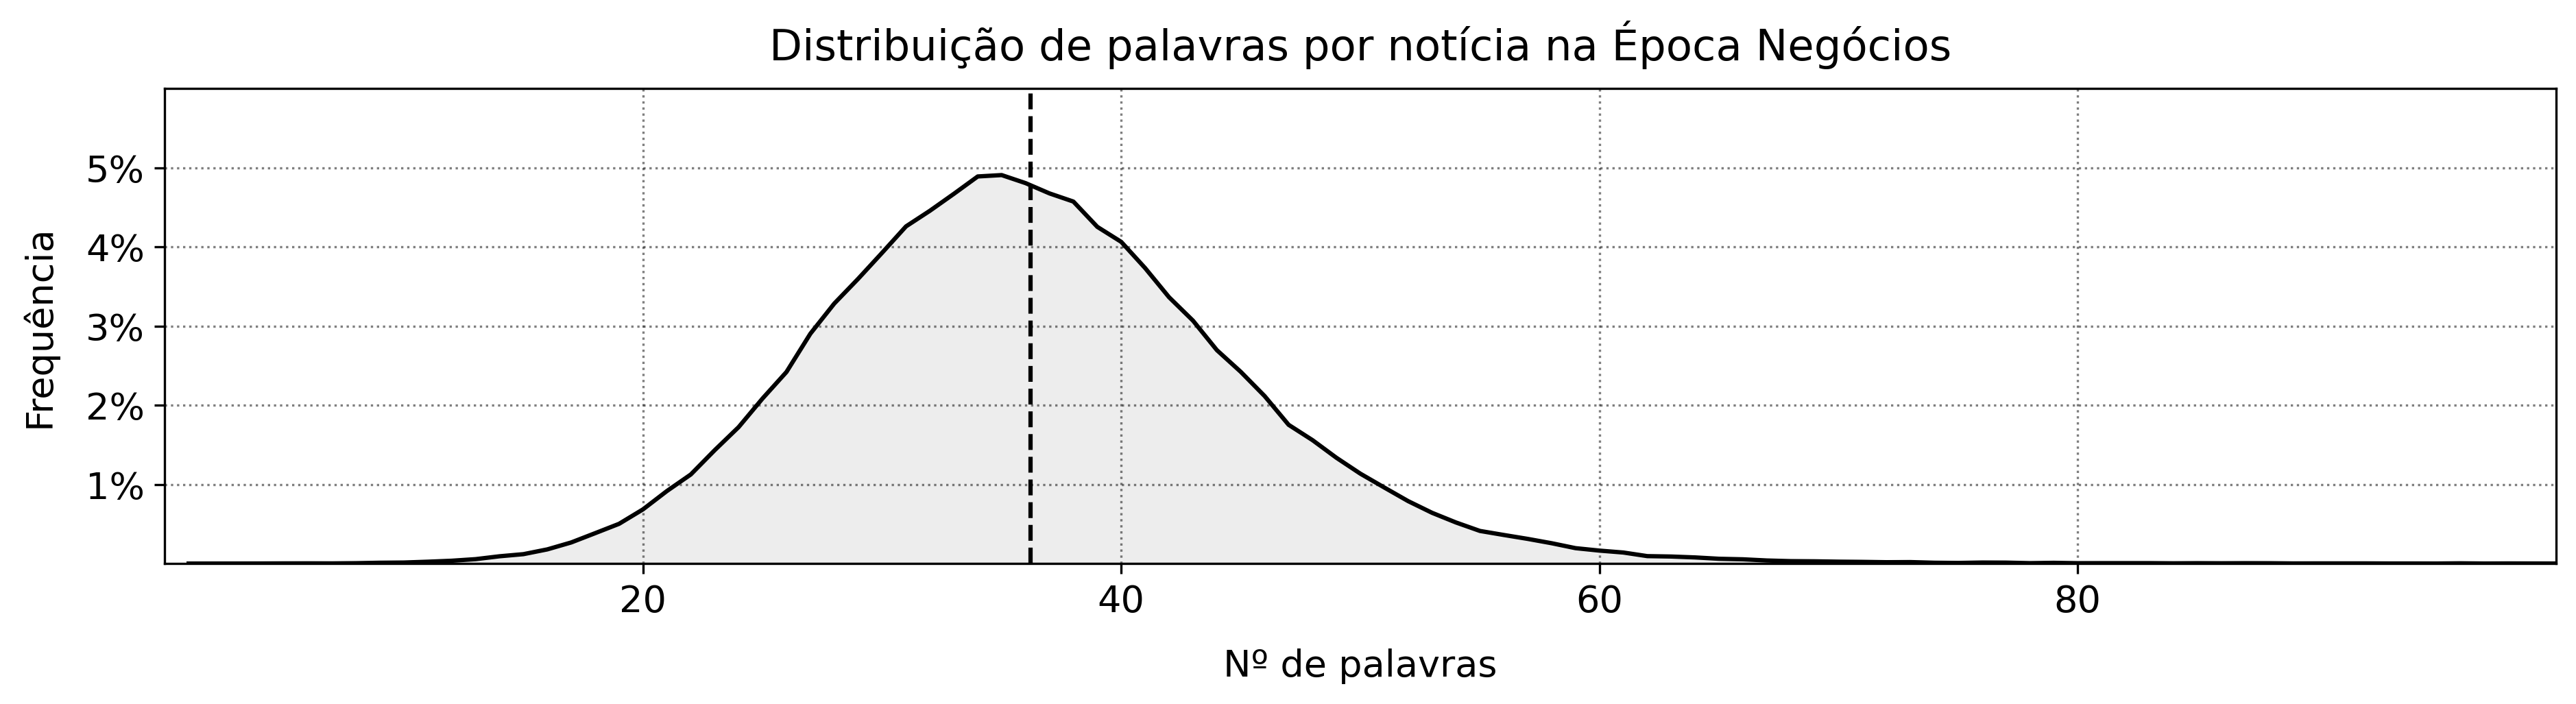

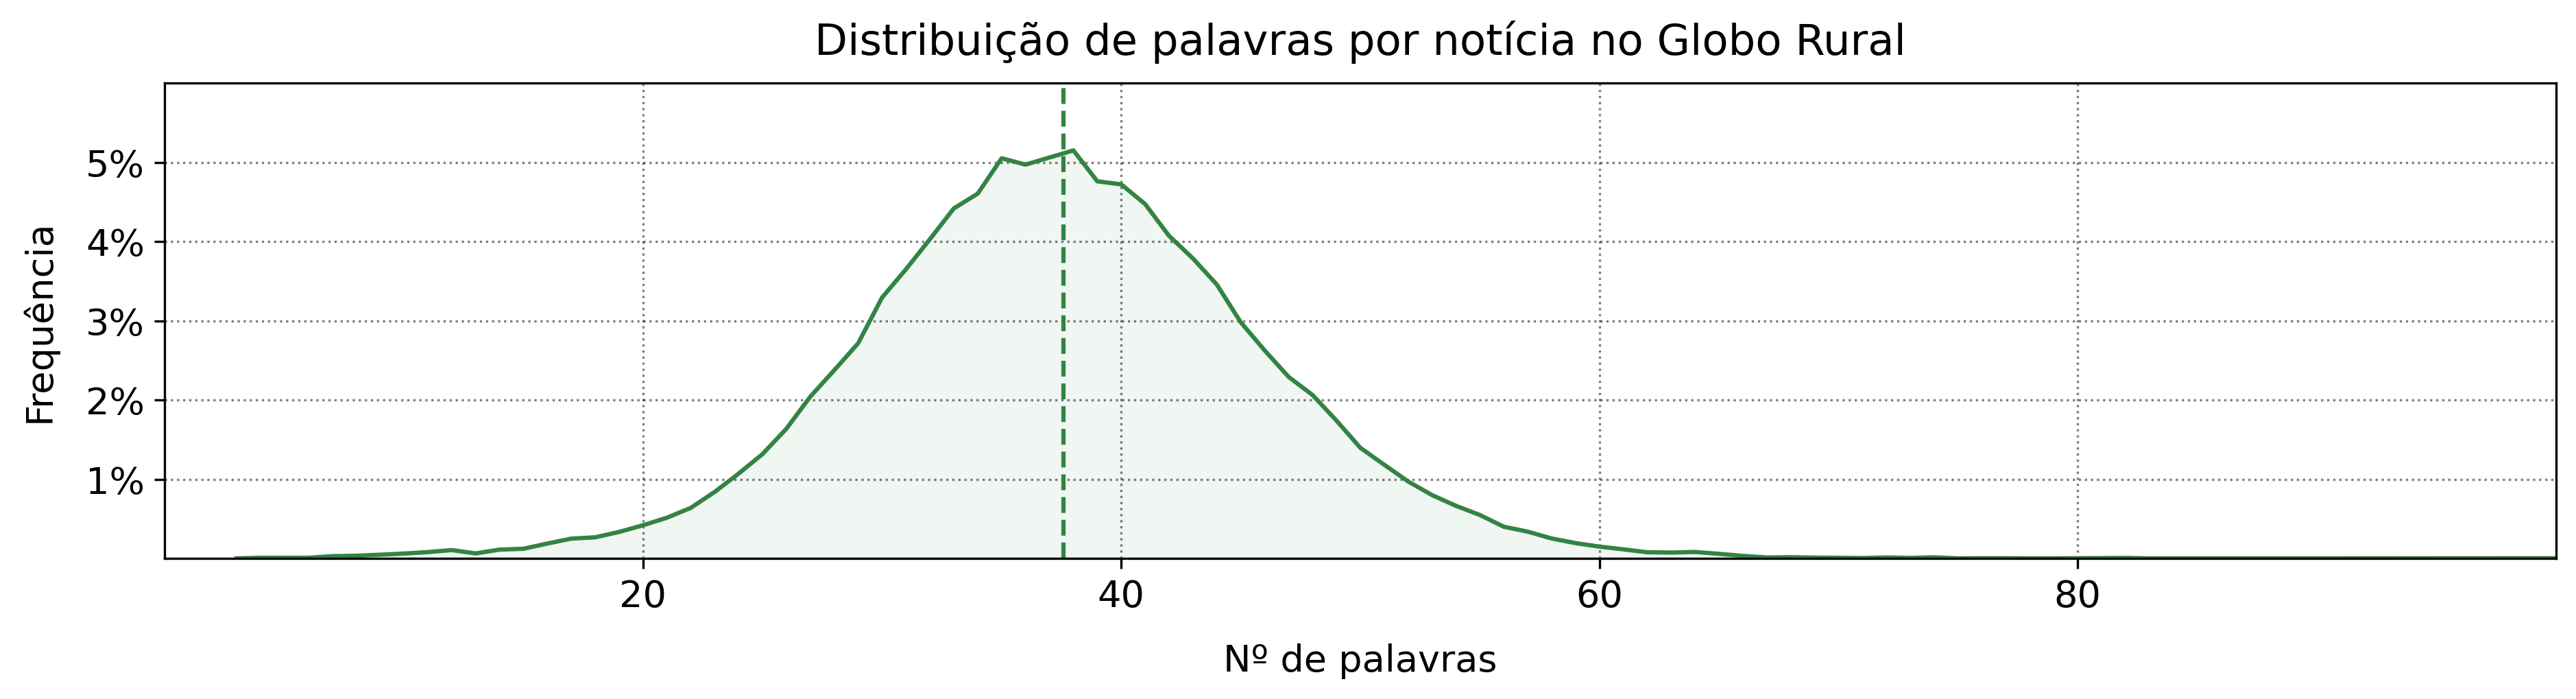

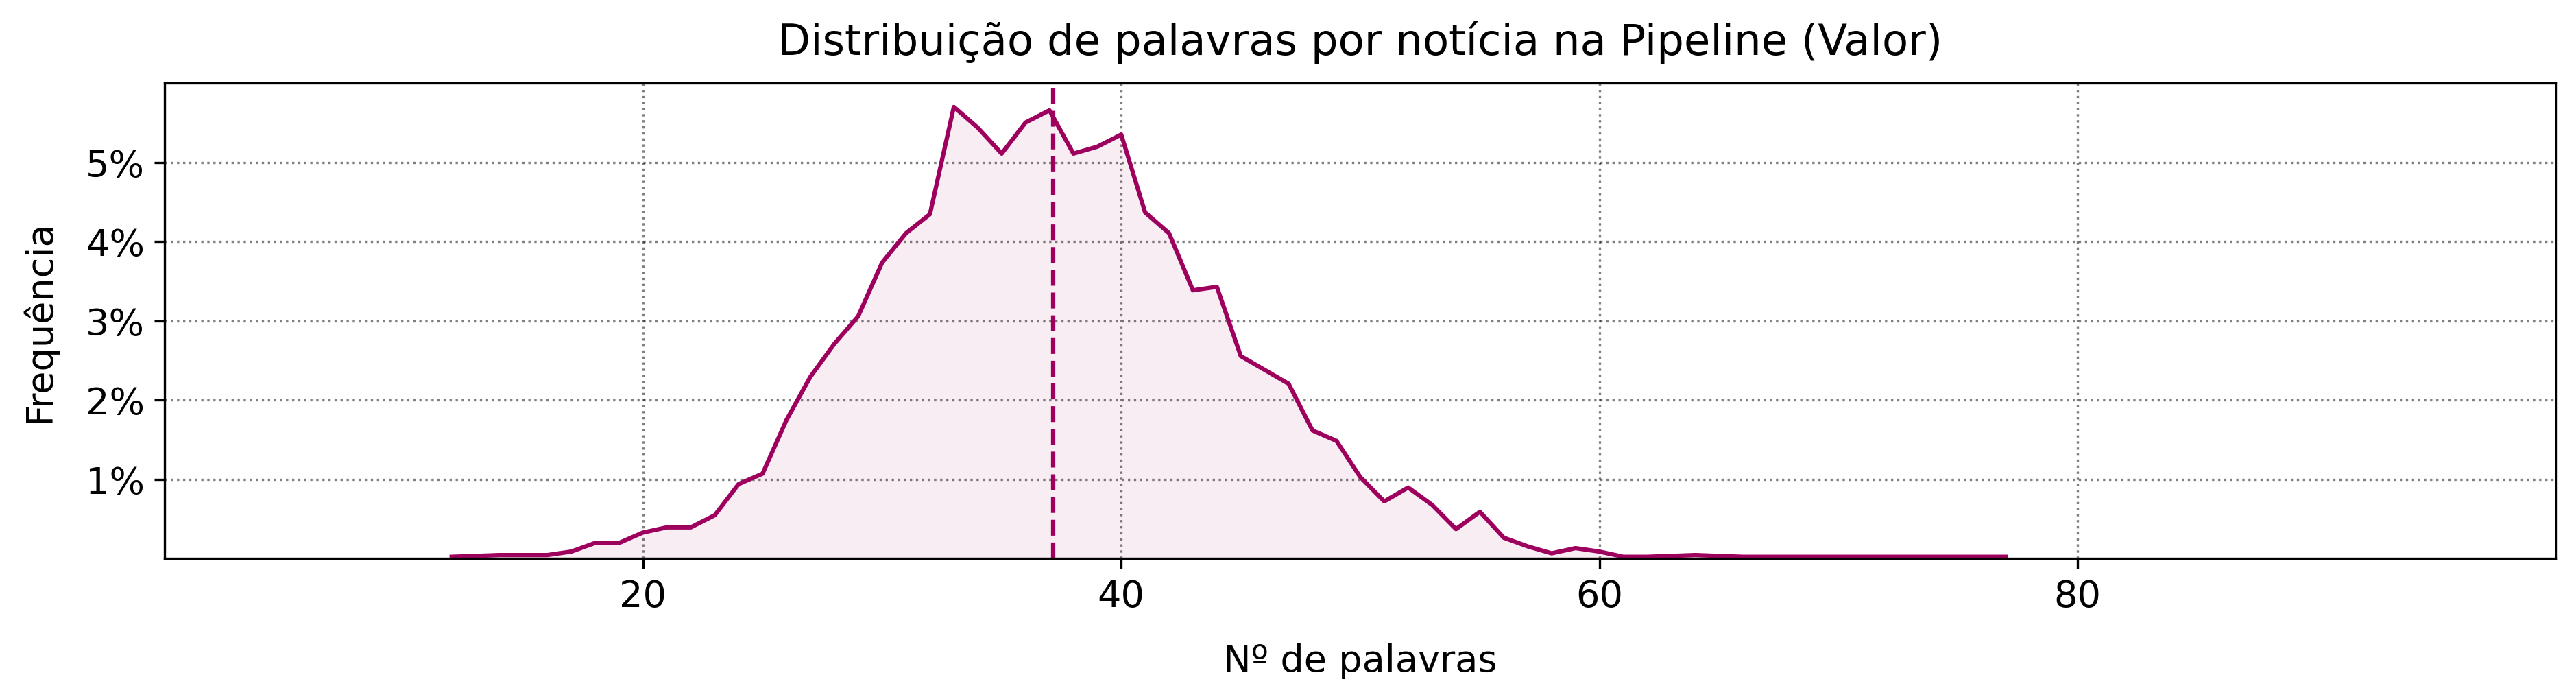

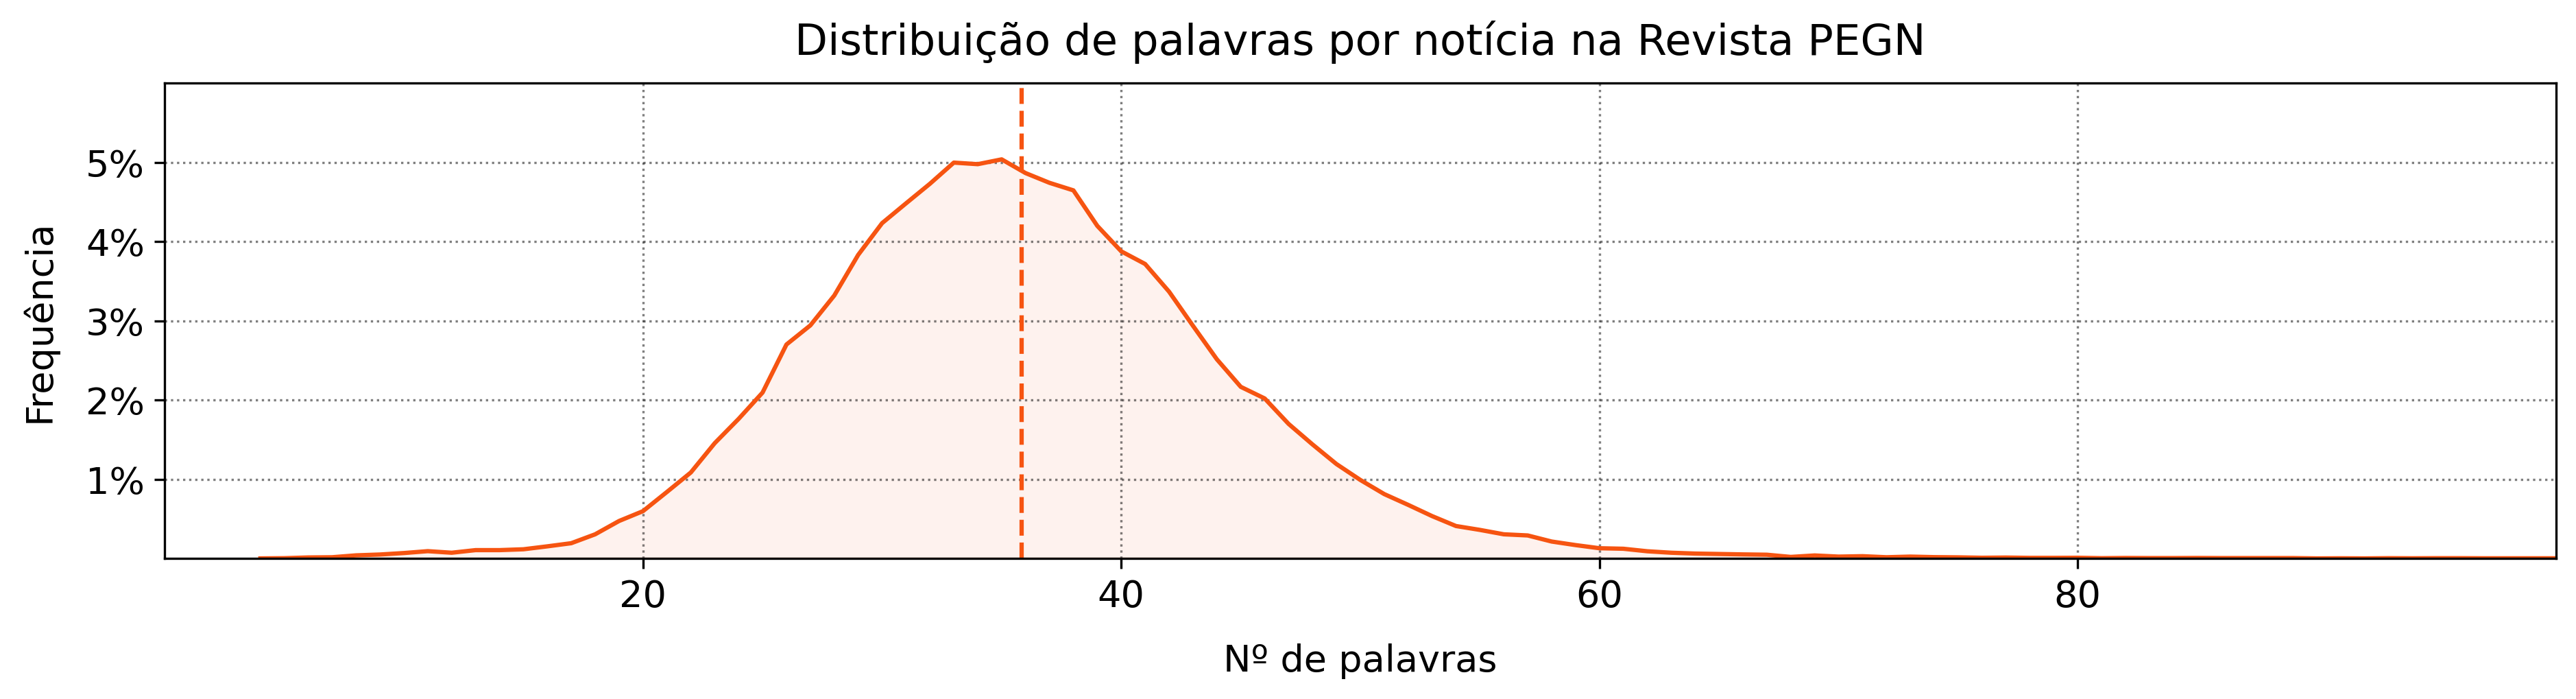

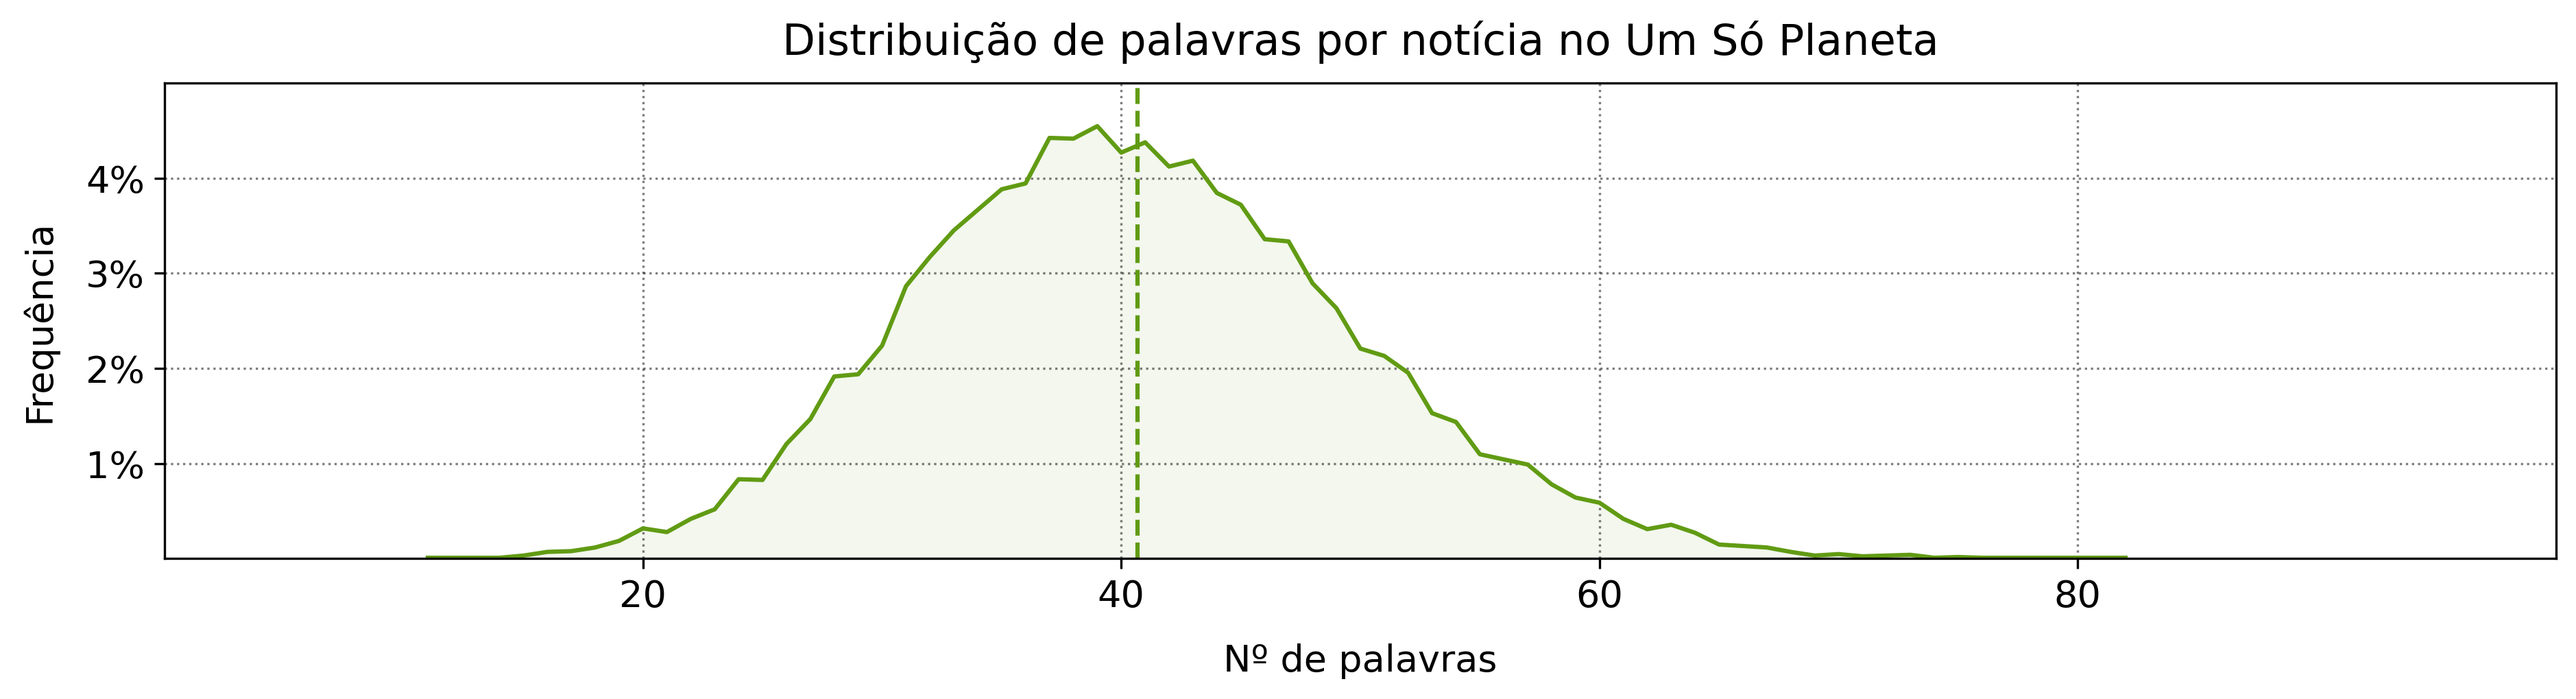

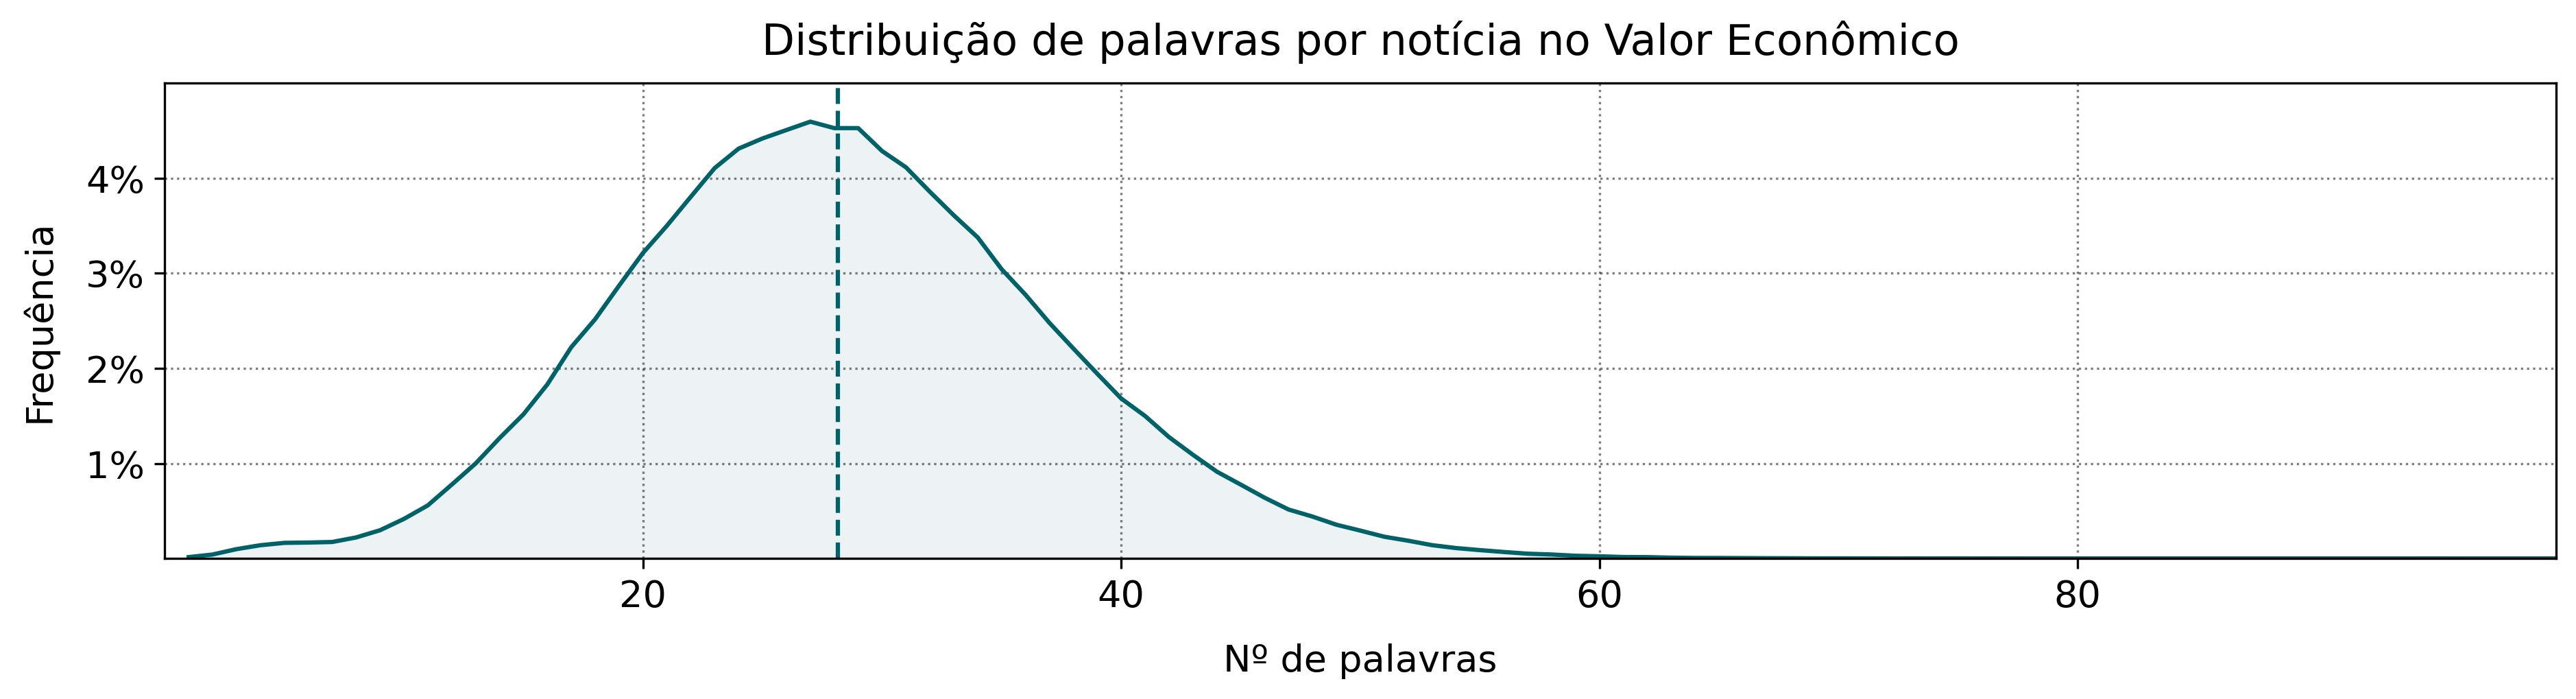

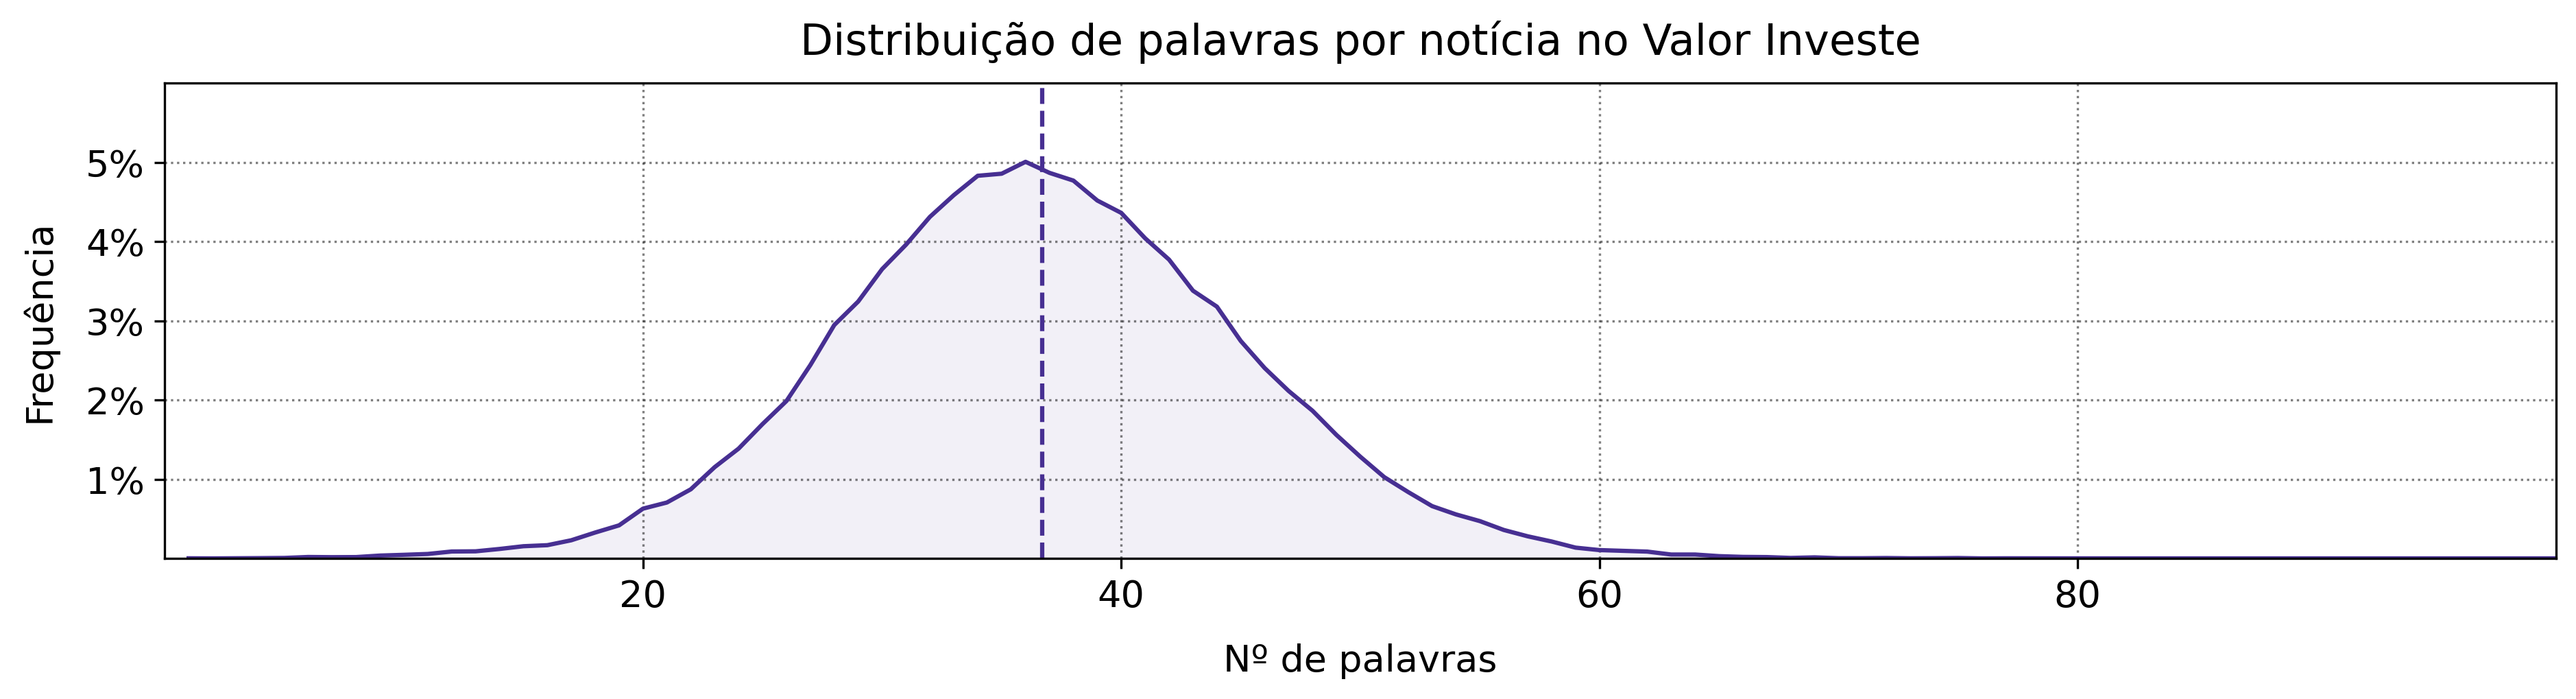

In [6]:
for seleção in sorted(cores.keys()):
    distribuição_de_palavras(seleção)

# Amostragem aleatória

In [7]:
import pandas as pd
df = pd.read_parquet('bases para o LDA/valor - total.parquet')

In [47]:
import random
url, data, corpus, portal = df.iloc[random.randint(0, len(df)-1)]
print(url, '\n')
print(corpus)

https://valor.globo.com/politica/noticia/2015/06/13/pt-aprova-resolucao-sem-criticas-a-politica-economica.ghtml 

pt aprova resolução críticas política econômica comando pt defesa mudanças rumo política econômica petistas aprovar resolução congresso salvador ba documento críticas ajuste fiscal ministro fazenda única emenda conduzir orientação política econômica retomar crescimento garantir direitos sociais
